In [1]:
%run ../Utils/FGindex_function.ipynb
%run ../Utils/portfolio_metrics.ipynb
%run ../Utils/Backtesting_function.ipynb

In [2]:
from pykrx import stock
from pykrx import bond

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from operator import itemgetter
from datetime import date, datetime
import time
from collections import Counter

# Index

In [4]:
best_parameter = pd.read_csv('../Backtest/index_final_result.csv')

In [5]:
best_parameter

Unnamed: 0  ticker  buying_point  selling_point  best_score  market_score  \
0            0    1001           0.3            0.8     2449.15       2405.27   
1            1    1002           0.1            0.8     2392.34       2392.34   
2            2    1003           0.1            0.8     2936.28       2657.00   
3            3    1004           0.1            0.9     2176.15       2176.15   
4            4    1005           0.2            0.9     4162.89       3648.31   
..         ...     ...           ...            ...         ...           ...   
83          83    2160           0.1            0.8     2043.04       1072.19   
84          84    2181           0.1            0.7     1501.28       1444.34   
85          85    2182           0.1            0.8     1423.14       1423.14   
86          86    2183           0.1            0.9     1584.20       1584.20   
87          87    2184           0.1            0.9     5927.50       3927.36   

         per  
0   1.018243  
1   1.000000  
2   1.105111  
3   1.000000  
4   1.141046  
..       ...  
83  1.905483  
84  1.039423  
85  1.000000  
86  1.000000  
87  1.509284  

[88 rows x 7 columns]

In [6]:

# 각 세부항목별 이상치 플랏팅, 이상치 추출 
def plotting_Risk(ticker, standard, path, save_folder, thres= 1.96, log_transform=False, detect = "1"):
    
    if path == 'data_FGscore':
        fig, ax = plt.subplots(figsize=(13,3))
        stock = pd.read_csv("../DATA/{}/{}.csv".format(path, ticker))
        stock.columns = ["index","datetime","close",'volume','multiple_volume','per','Volatility_list','Volume_list','S1_score','S2_score',"FG_score"]
        stock = stock.sort_values("datetime").reset_index(drop=True)
        
    elif path == 'data_macro':
        fig, ax = plt.subplots(figsize=(13,3))
        stock = pd.read_csv("../DATA/{}/{}.csv".format(path, i), header = None)
        stock.columns = ["datetime","close"]
        stock = stock.sort_values("datetime").reset_index(drop=True)        
    
    datetime_list = [datetime.strptime(i,"%Y-%m-%d").date() for i in stock.datetime]
    stock["datetime"] = datetime_list
        
    # data 소스 변경
    col_date = stock.datetime
    
    # log transformation 수행
    if log_transform==False:
        diff_data = list(stock.close)
    else:
        diff_data = list(np.log(stock.close))
    
    # data preprocessing
    if standard == 1:
        anomaly_date, anomaly_value = np.nan, np.nan
        
    # 로그변환, time diff, 변동성을 통한 이상치 확인
    elif standard == 'diff':
        # plot
        diff_data = [np.nan,] + list(np.diff(diff_data))
        calcul_res = [i for i in diff_data if (i!=-np.inf and i!=np.inf) ]
        std_data = np.nanstd(calcul_res)
        mean_data = np.nanmean(calcul_res)        
        pe1 = mean_data+std_data*thres
        pe2 = mean_data-std_data*thres
        ax.axhline(y=pe1,color='r',linestyle='--',label='nomal_bound')
        ax.axhline(y=pe2,color='r',linestyle='--')
        
        # anomaly
        anomaly_index = [(index,value) for index,value in enumerate(diff_data) if (value > pe1) or (value < pe2)]
        anomaly_date = [col_date[i[0]] for i in anomaly_index]
        anomaly_value = [i[1] for i in anomaly_index]
        ax.scatter(anomaly_date,anomaly_value,color='red')
        
    elif standard == 'smoothing':
        # plot
        rolling_diff = list(pd.Series(diff_data).rolling(window=48,min_periods=1,center = True).mean())
        res = list(np.array(diff_data) - np.array(rolling_diff))

        calcul_res = [i for i in res if (i!=-np.inf and i!=np.inf) ]
        diff_data = res
        std_data = np.nanstd(calcul_res)
        mean_data = np.nanmean(calcul_res)    
        
        
        pe1 = mean_data+std_data*thres
        pe2 = mean_data-std_data*thres
        ax.axhline(y=pe1,color='r',linestyle='--',label='nomal_bound')
        ax.axhline(y=pe2,color='r',linestyle='--')
        
        # anomaly
        anomaly_index = [(index,value) for index,value in enumerate(res) if (value > pe1) or (value < pe2)]
        anomaly_date = [col_date[i[0]] for i in anomaly_index]
        anomaly_value = [i[1] for i in anomaly_index]
        ax.scatter(anomaly_date,anomaly_value,color='red')

    ax.plot(col_date,diff_data,label=ticker)
    ax.legend(loc="upper left")
    ax.set_title(ticker)
    ax.set_xlim([np.min(col_date),np.max(col_date)])
    anomaly = anomaly_date
    anomaly_value = (anomaly_value - mean_data) / std_data
    
    plt.savefig('../DATA/{}/{}.png'.format(save_folder,ticker))
    
    max_date = np.max(stock.datetime)
    min_date = np.min(stock.datetime)
    
    return list(anomaly), list(anomaly_value), min_date, max_date
    

In [7]:

stock = pd.read_csv("../DATA/{}/{}.csv".format("data_FGscore", '1001'))
stock.columns = ["index","datetime","close",'volume','multiple_volume','per','Volatility_list','Volume_list','S1_score','S2_score',"FG_score"]
stock = stock.sort_values("datetime").reset_index(drop=True)
datetime_list = [datetime.strptime(i,"%Y-%m-%d").date() for i in stock.datetime]
stock["datetime"] = datetime_list


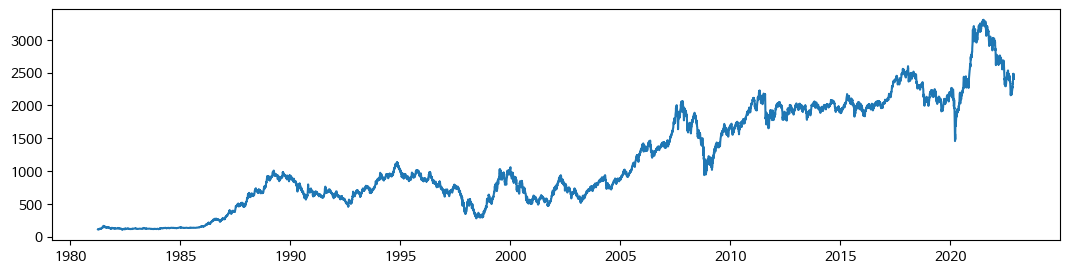

In [8]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(stock.datetime,stock.close)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


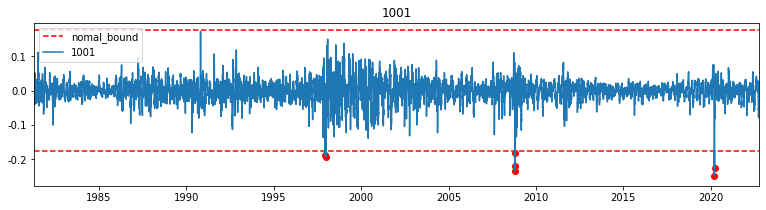

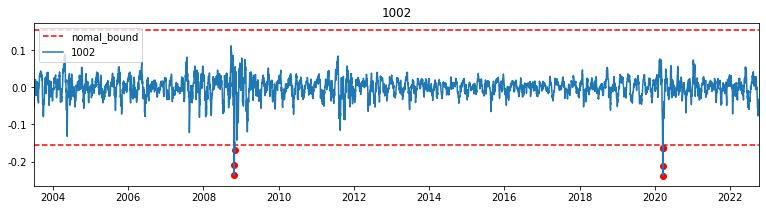

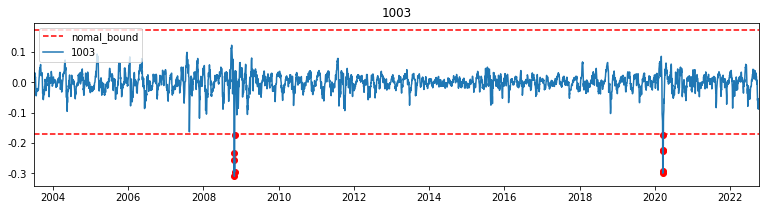

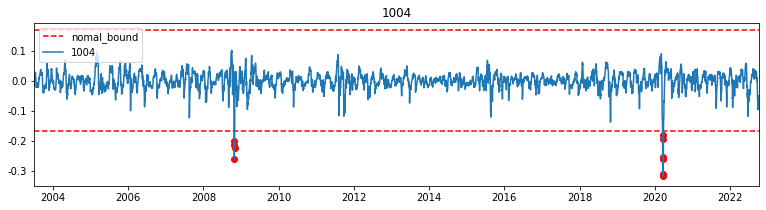

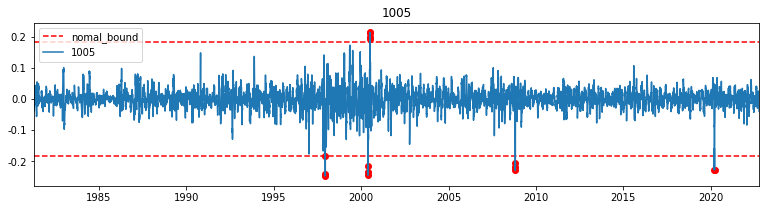

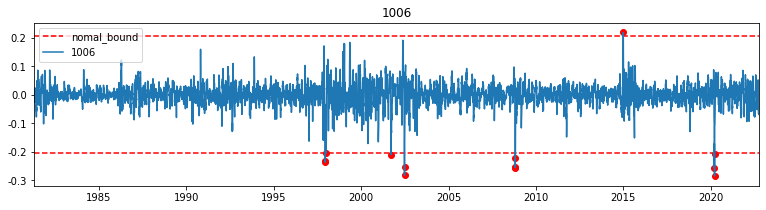

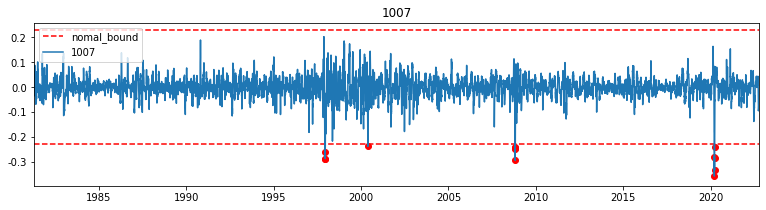

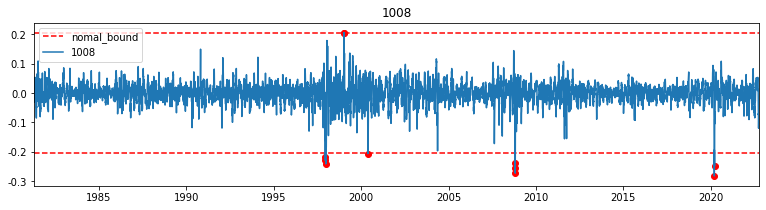

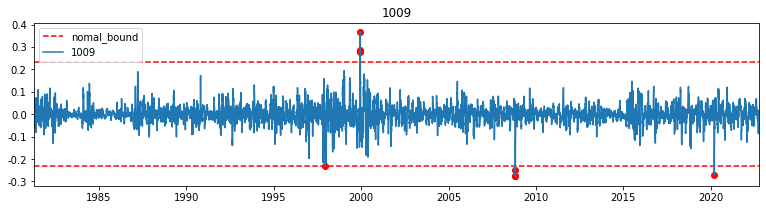

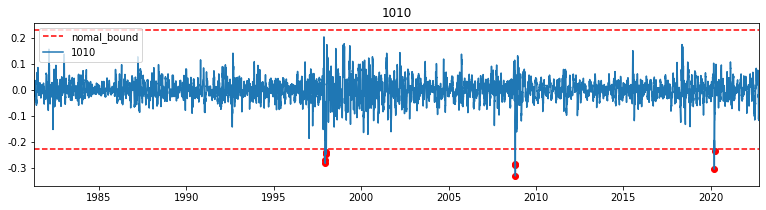

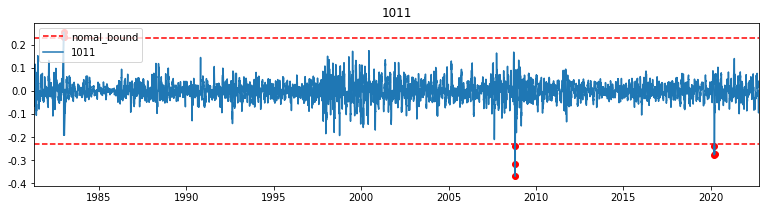

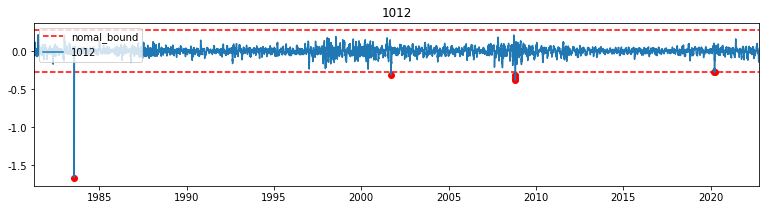

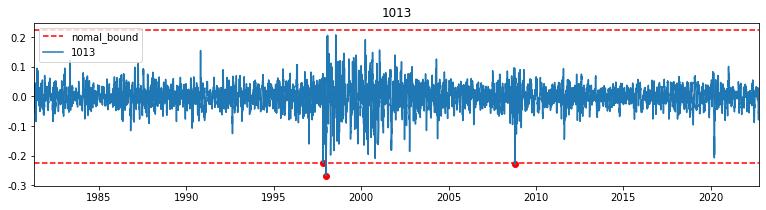

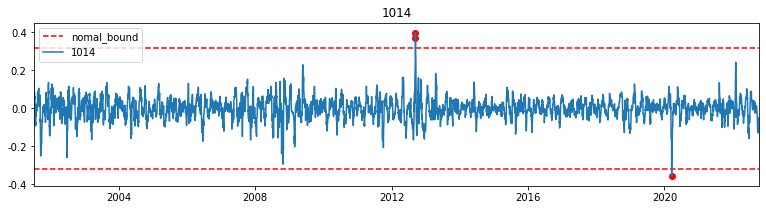

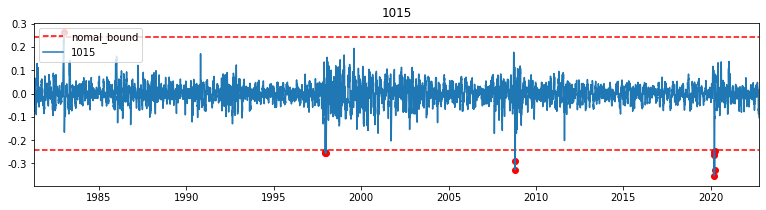

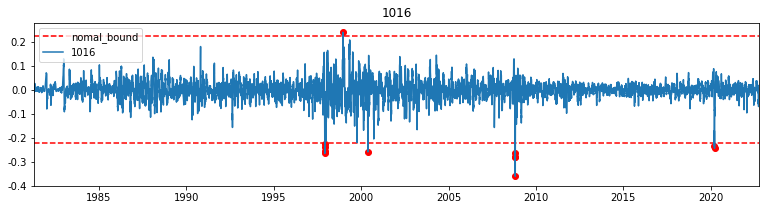

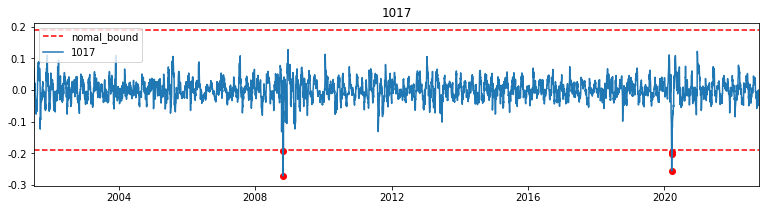

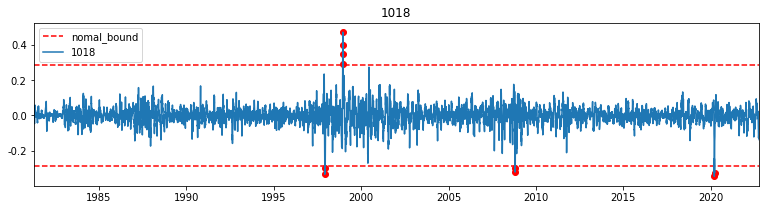

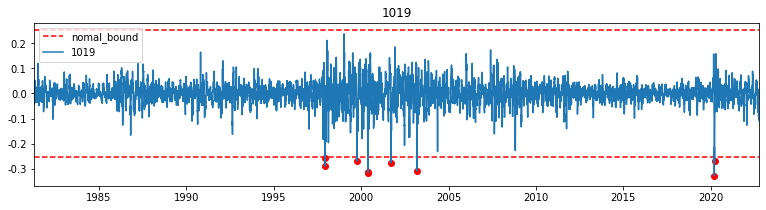

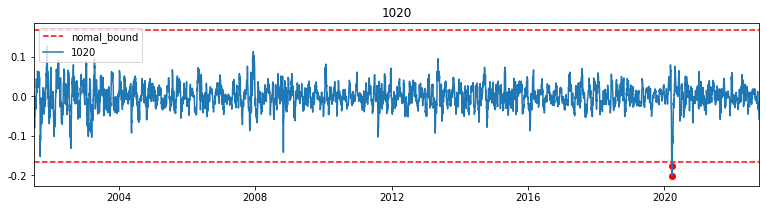

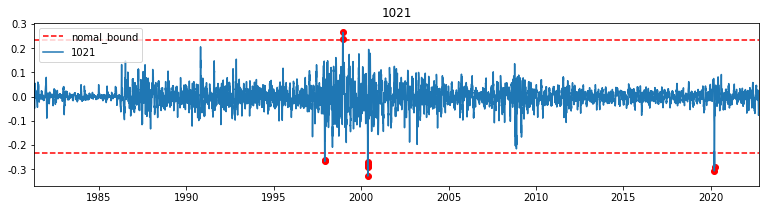

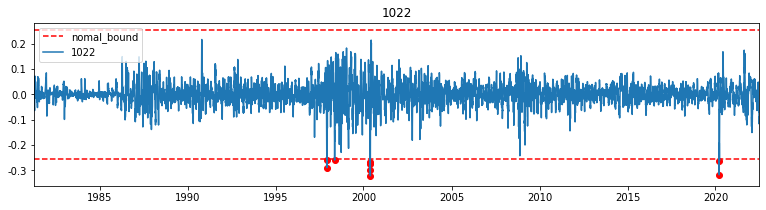

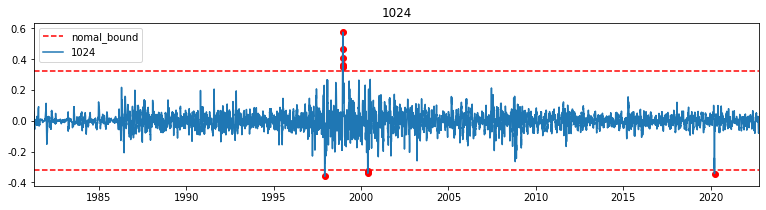

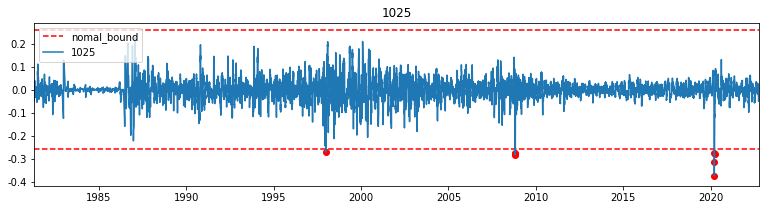

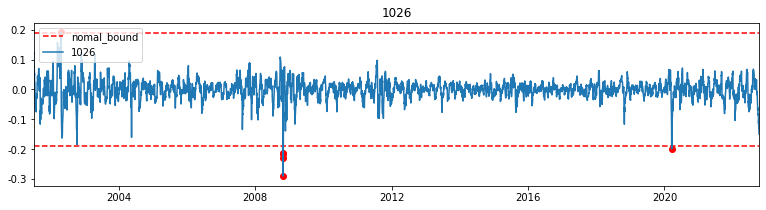

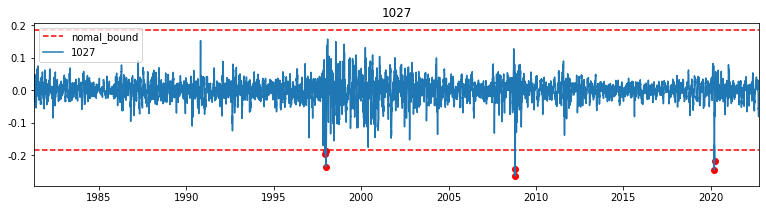

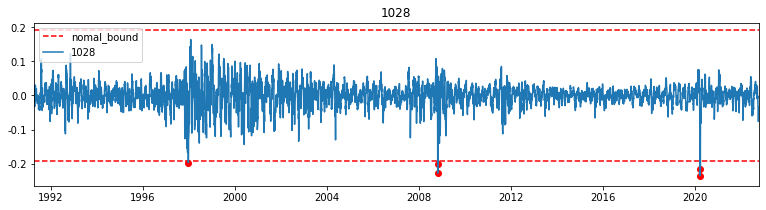

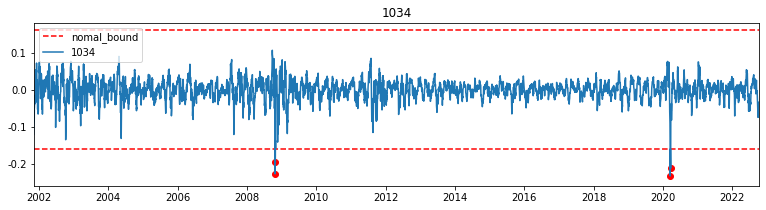

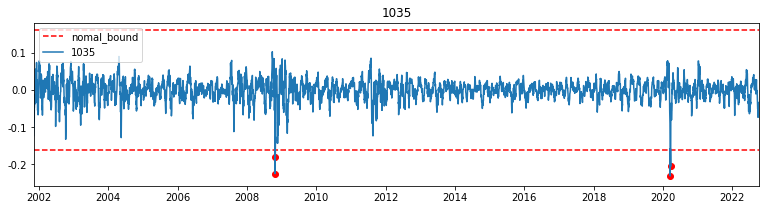

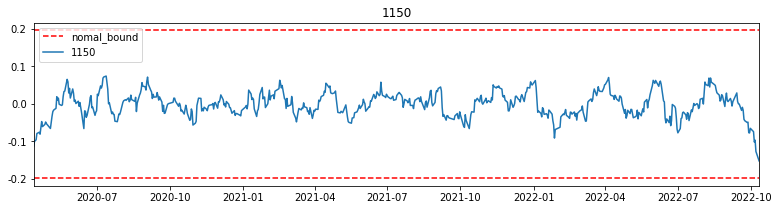

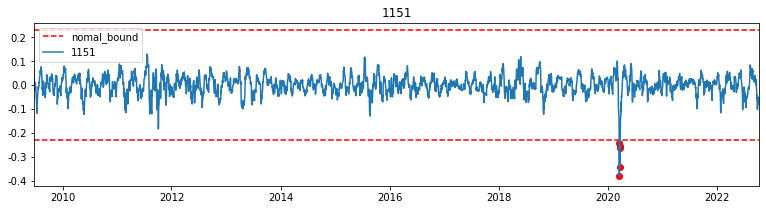

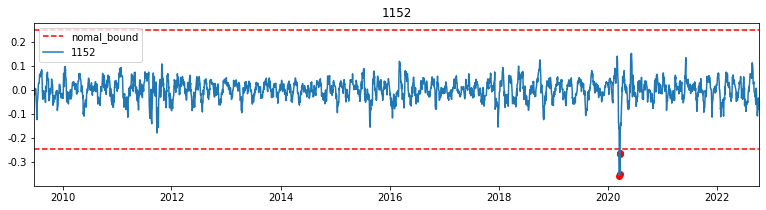

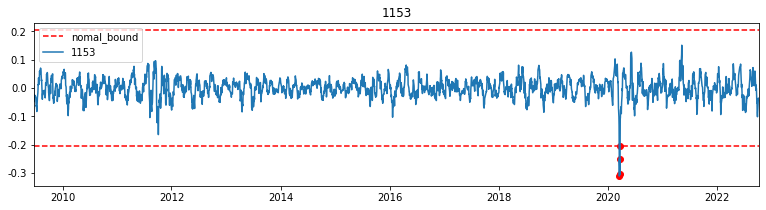

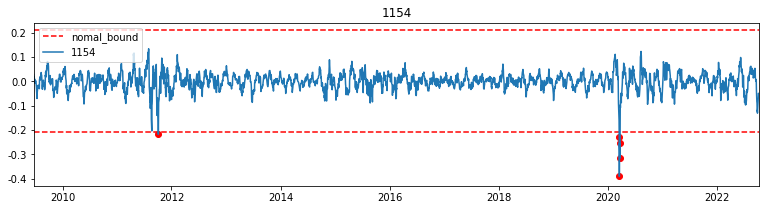

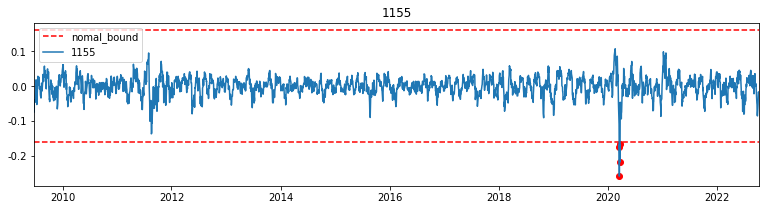

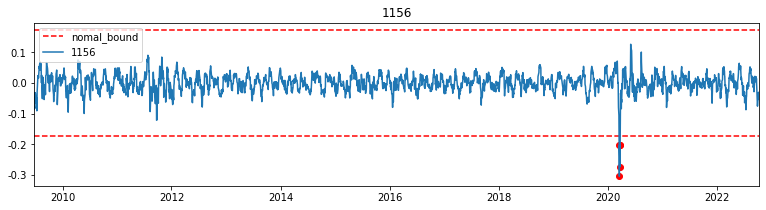

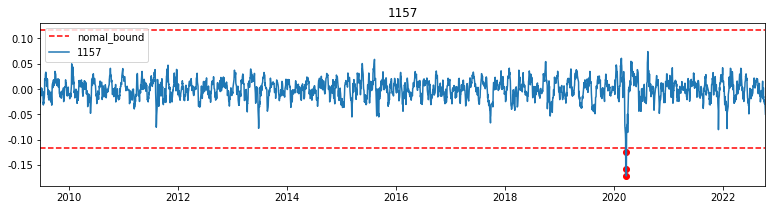

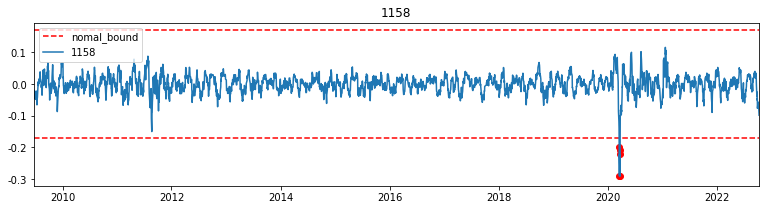

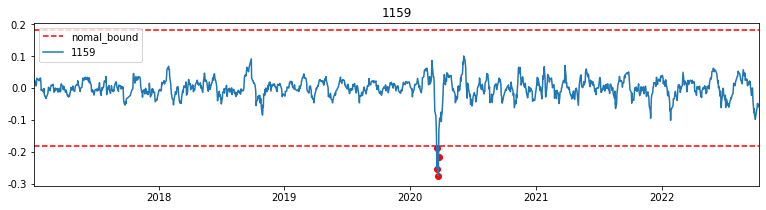

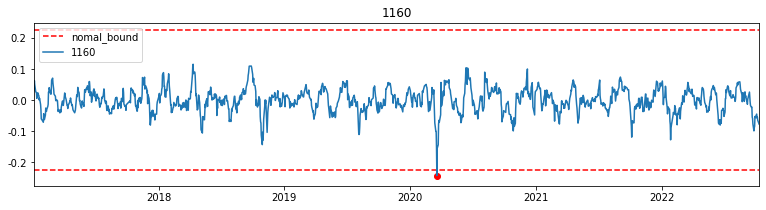

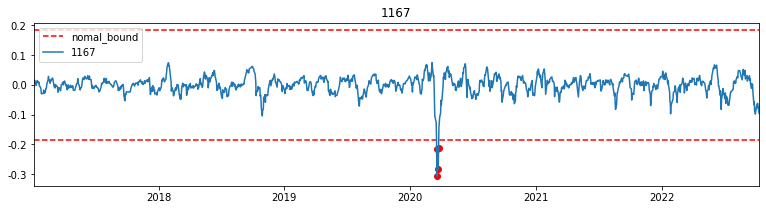

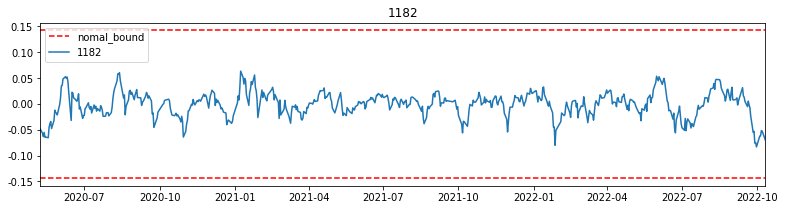

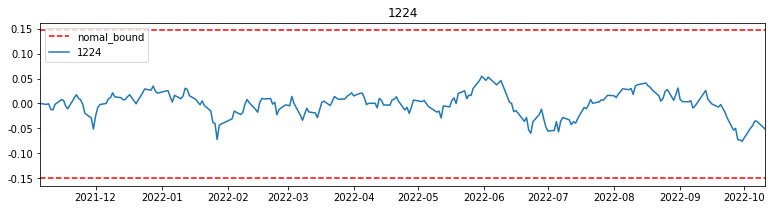

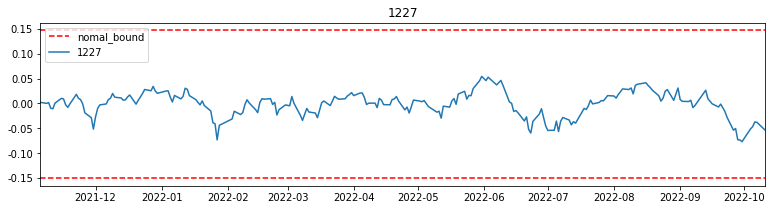

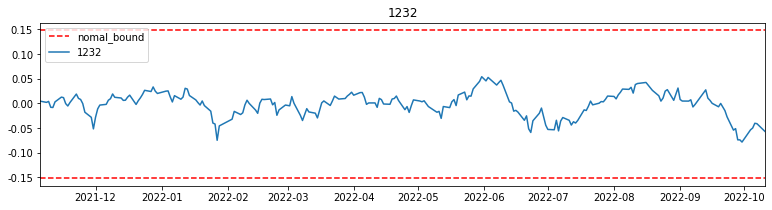

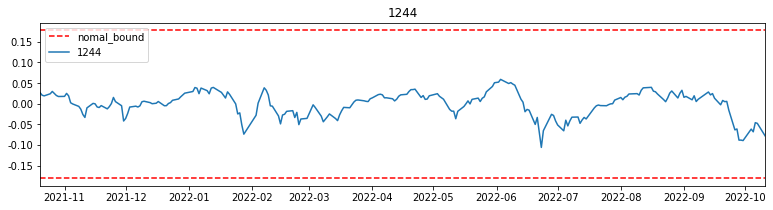

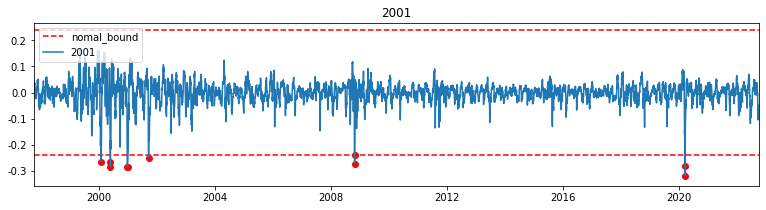

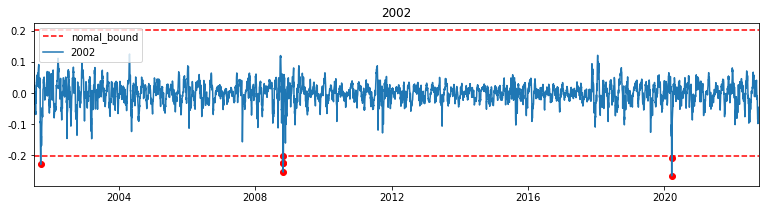

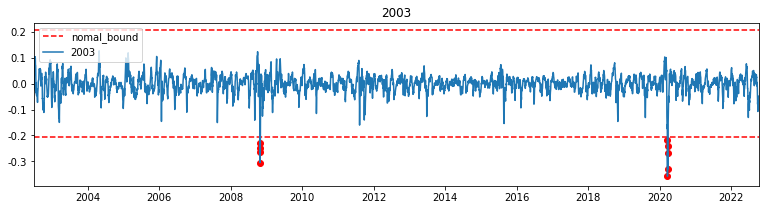

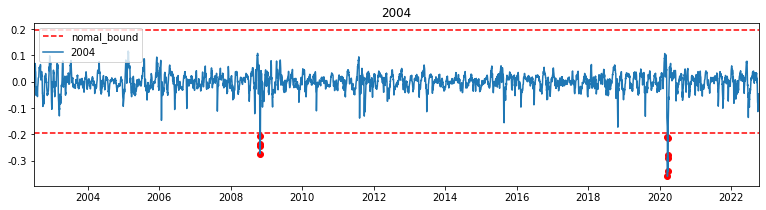

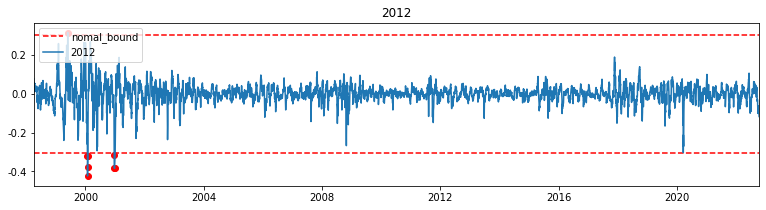

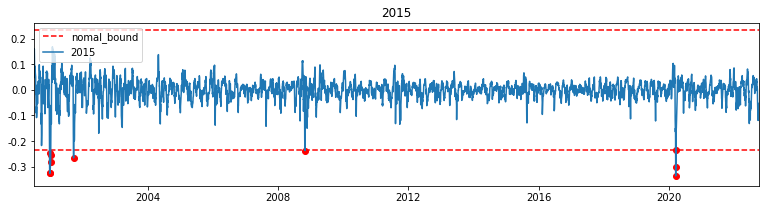

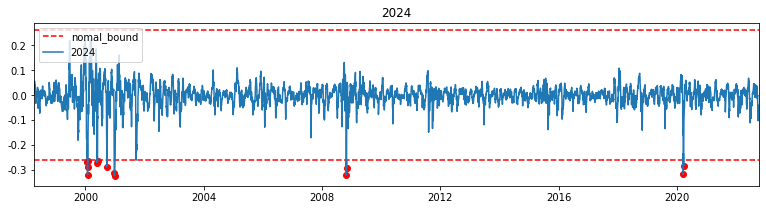

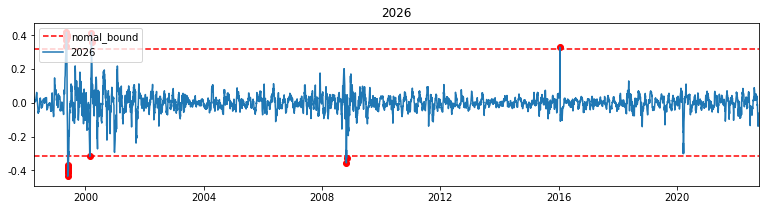

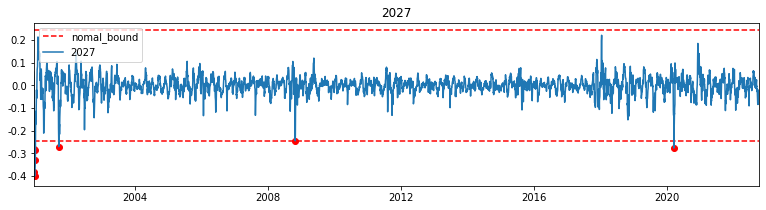

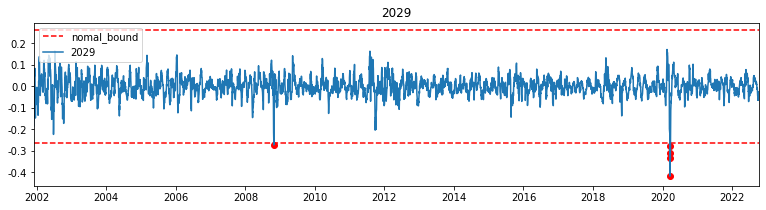

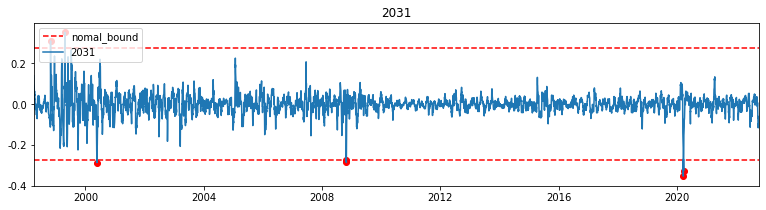

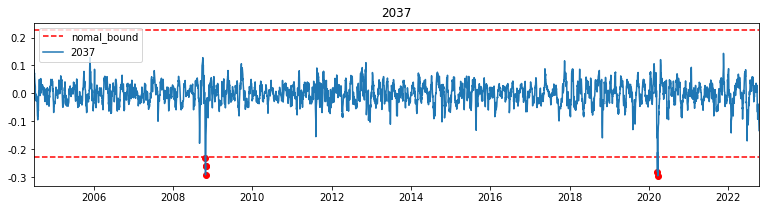

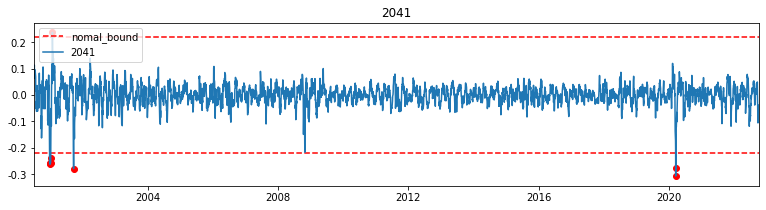

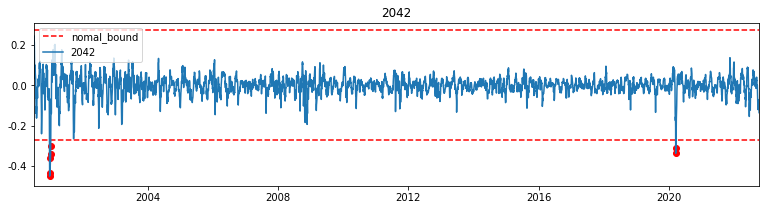

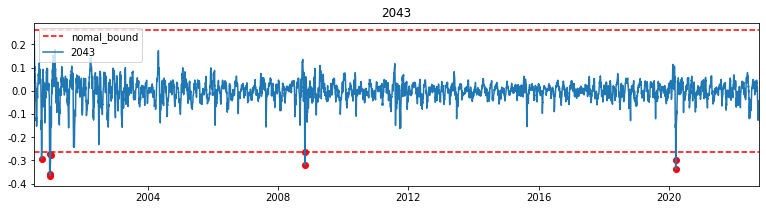

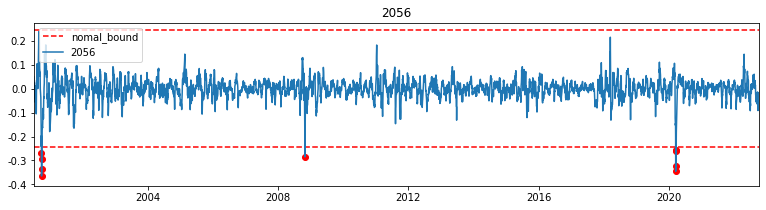

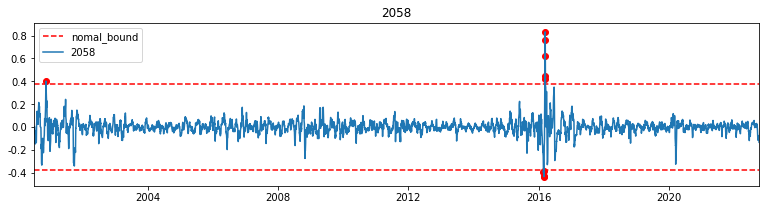

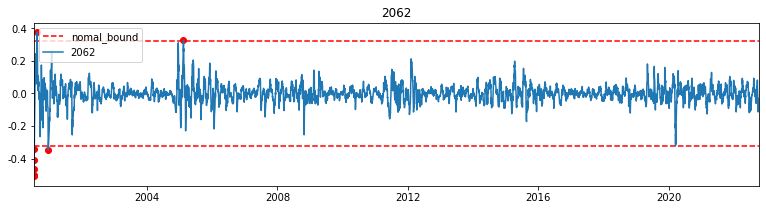

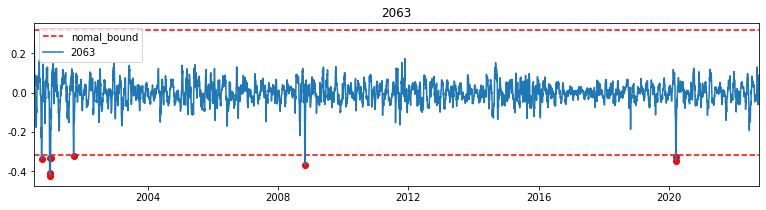

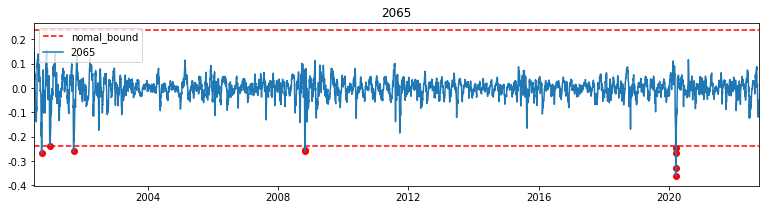

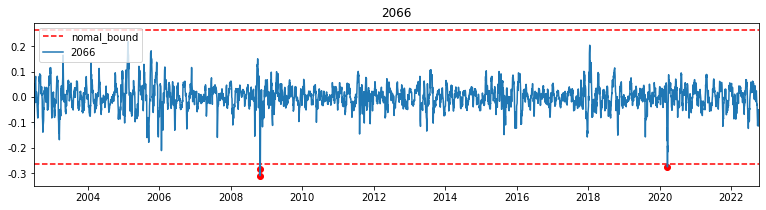

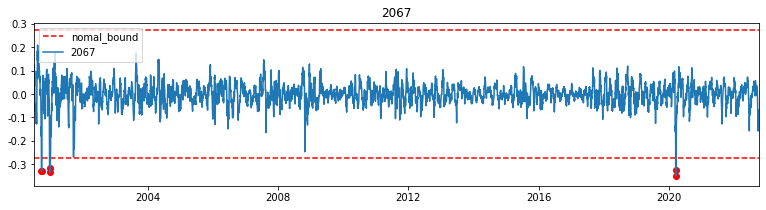

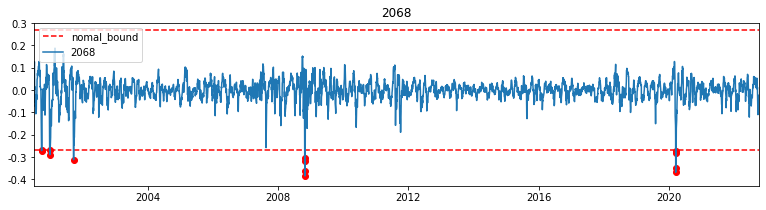

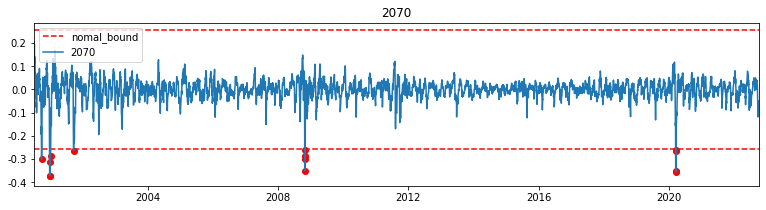

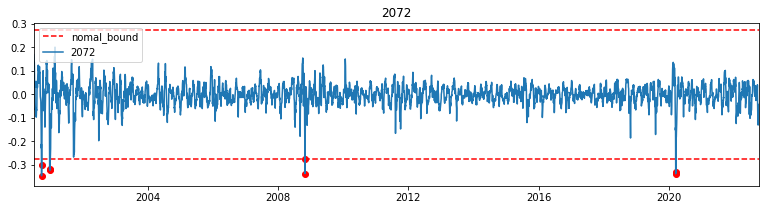

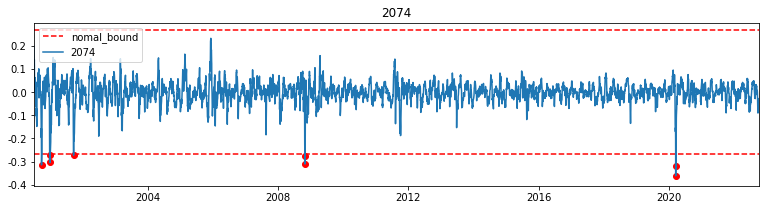

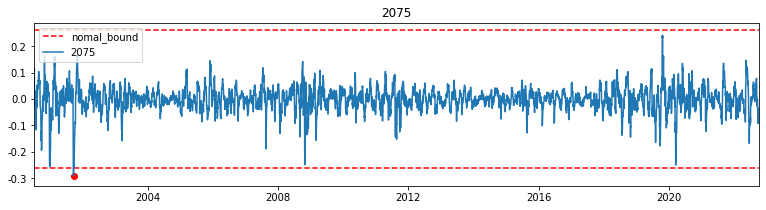

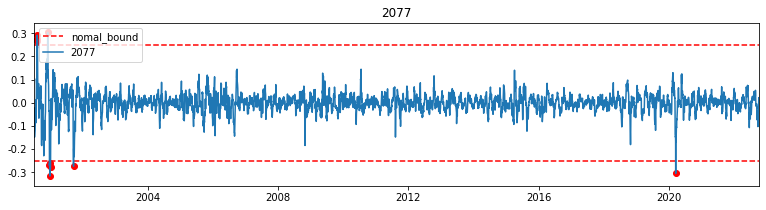

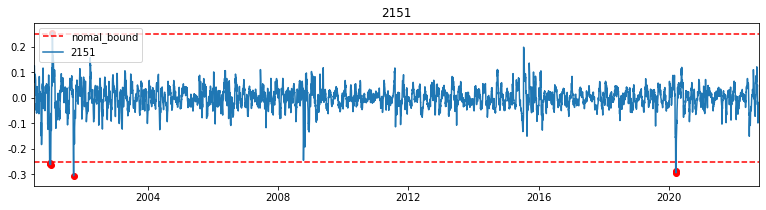

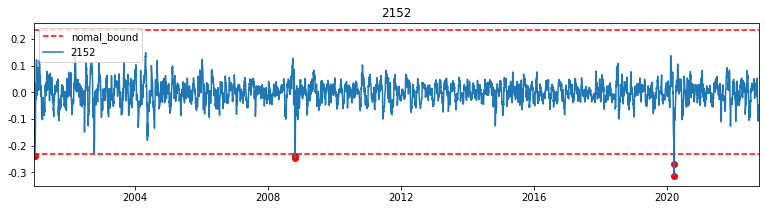

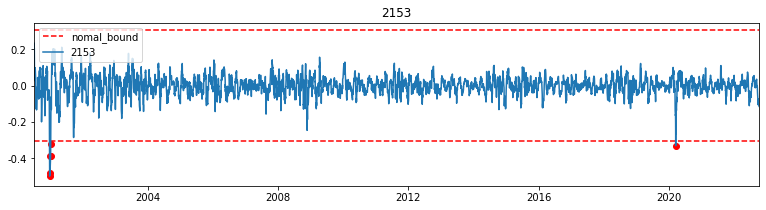

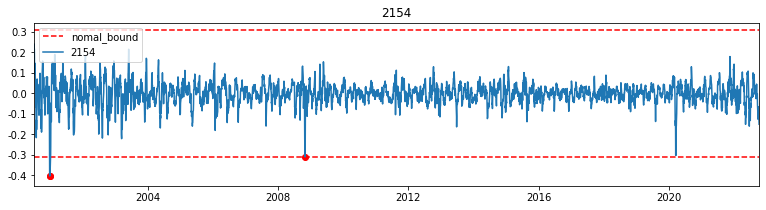

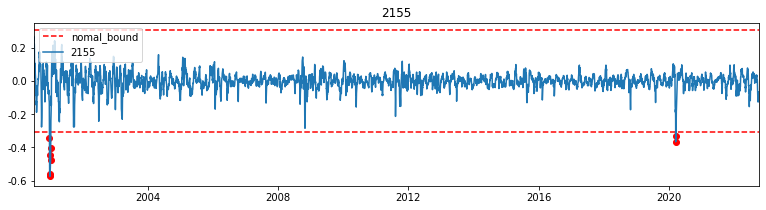

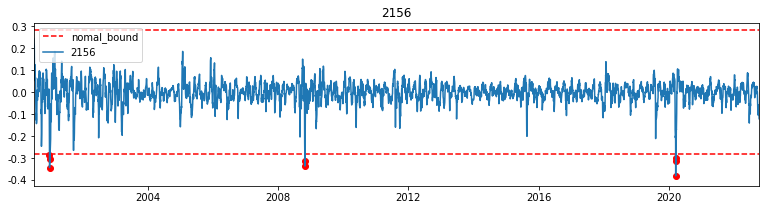

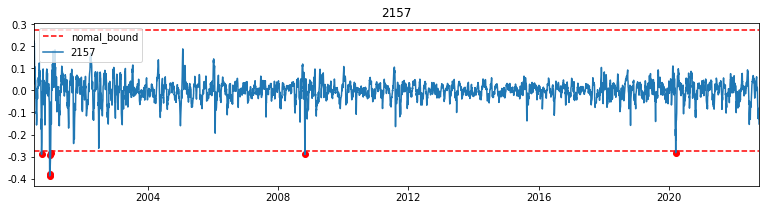

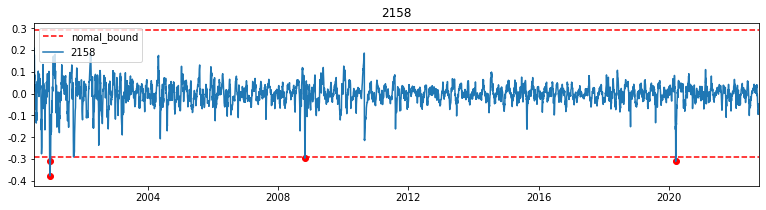

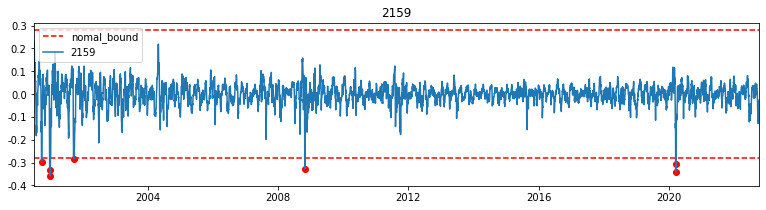

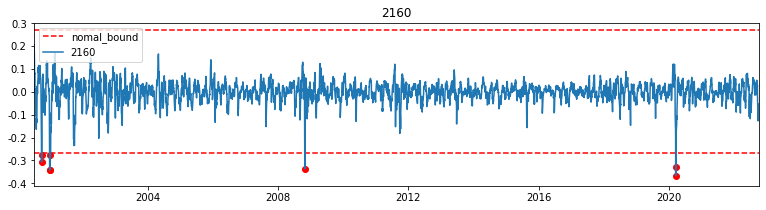

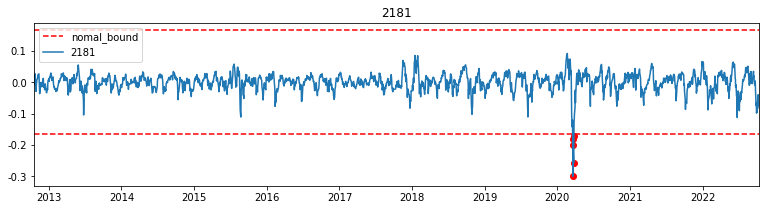

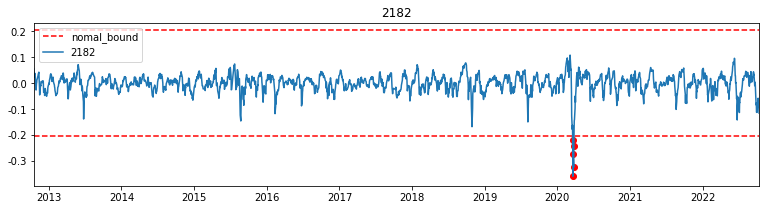

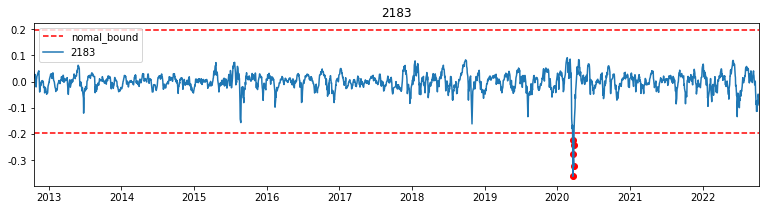

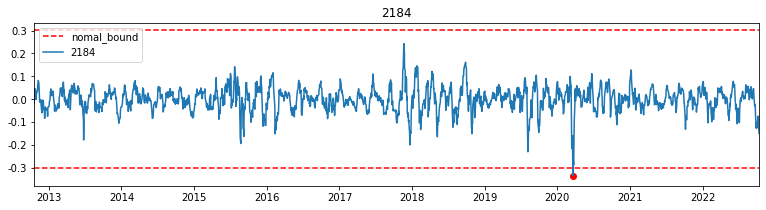

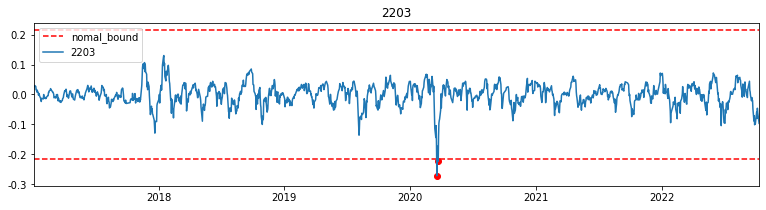

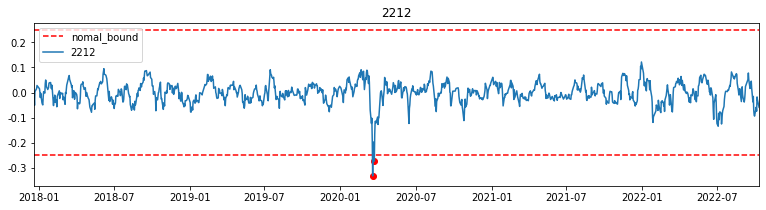

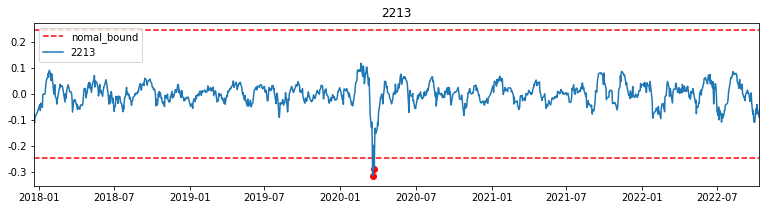

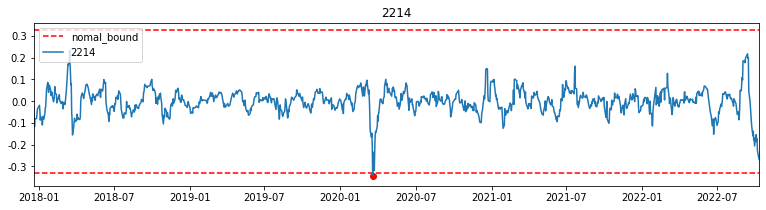

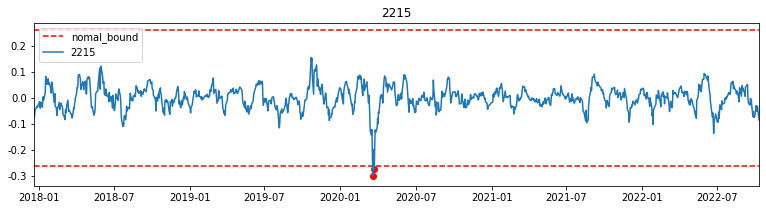

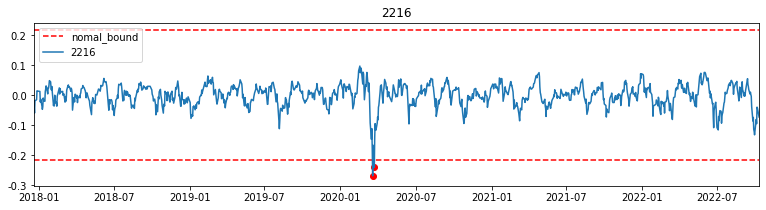

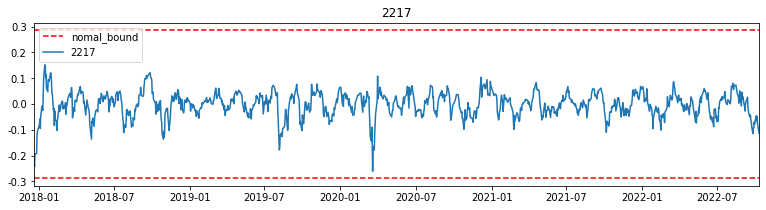

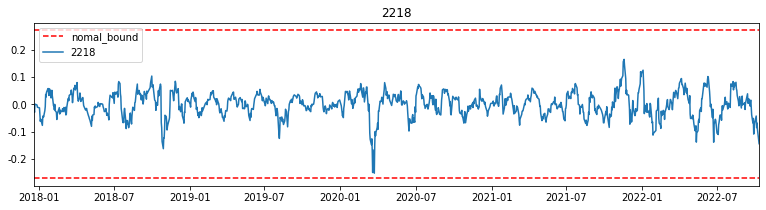

In [9]:
anomaly_date_list = []
anomaly_value_list = []
min_date_list = []
max_date_list = []
for i in final_result_df.index:
    # data read
    
    ticker = final_result_df.ticker[i]
    anomaly_date,anomaly_value, min_date, max_date = plotting_Risk('{}'.format(ticker),
                                                                     'smoothing','data_FGscore','index_anomaly',
                                                                     thres= 6, log_transform=True)
    anomaly_date_list = anomaly_date_list + anomaly_date
    anomaly_value_list = anomaly_value_list + anomaly_value
    
    min_date_list.append(min_date)
    max_date_list.append(max_date)
    

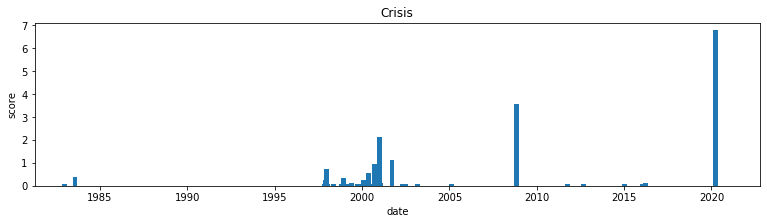

In [10]:

index_factor = pd.DataFrame(zip(anomaly_date_list,np.abs(anomaly_value_list)), columns = ["date","weight"])
index_factor = index_factor.groupby("date")["weight"].sum()
index_factor = pd.DataFrame(index_factor).reset_index()
index_factor['weight'] = index_factor['weight']/len(final_result_df)

fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 100)
ax.set_xlim([np.min(min_date_list),np.max(max_date_list)])
ax.set_title("Crisis")
ax.set_ylabel('score')
ax.set_xlabel('date')
plt.show()


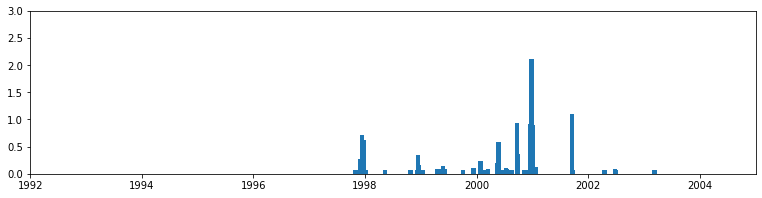

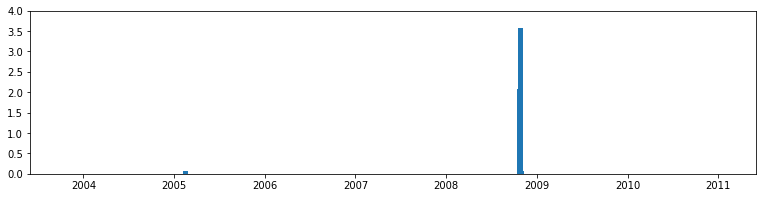

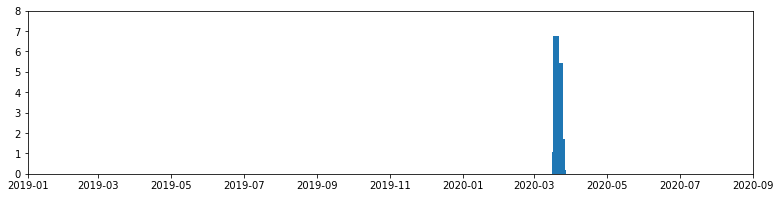

In [11]:
#6
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 30)
ax.set_xlim([datetime.strptime('1992-01-01','%Y-%m-%d'),datetime.strptime('2005-01-01','%Y-%m-%d')])
ax.set_ylim([0,3])
plt.show()

#6
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 20)
ax.set_xlim([datetime.strptime('2003-06-01','%Y-%m-%d'),datetime.strptime('2011-06-01','%Y-%m-%d')])
ax.set_ylim([0,4])
plt.show()

#6
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 5)
ax.set_xlim([datetime.strptime('2019-01-01','%Y-%m-%d'),datetime.strptime('2020-09-01','%Y-%m-%d')])
ax.set_ylim([0,8])
plt.show()

# Macro

In [12]:
macro_list = [
    "CPIAUCSL","WPSFD49207","DPCCRC1M027SBEA","PCE"
    ,"XTEXVA01USM659S","XTIMVA01USM659S","A822RO1Q156NBEA","B006RO1Q156NBEA"
    ,"A191RO1Q156NBEA","A001RO1Q156NBEA"
    ,"CP","TCU"
    ,"UNRATE","GFDEGDQ188S"
    ,"DFF","DTB3","DTB6","DGS1","DGS2","DGS3","DGS5","DGS7"
    ,"DGS10","DGS20","DGS30"
    ,"DAAA","DBAA"
    ,"TEDRATE"
    ,"T3MFF","T6MFF","T1YFF","T5YFF","T10YFF"
    ,"T10Y2Y","T10Y3M"
    ,"AAAFF","BAAFF"
    ,"AAA10Y","BAA10Y"
]

macro_list1 = [
    "CPIAUCSL","WPSFD49207","DPCCRC1M027SBEA","PCE"
    ,"XTEXVA01USM659S","XTIMVA01USM659S","A822RO1Q156NBEA","B006RO1Q156NBEA"
    ,"A191RO1Q156NBEA","A001RO1Q156NBEA"
    ,"CP","TCU"
    ,"UNRATE","GFDEGDQ188S"
]

macro_list2 = [
    "DFF","DTB3","DTB6","DGS1","DGS2","DGS3","DGS5","DGS7"
    ,"DGS10","DGS20","DGS30"
    ,"DAAA","DBAA"
    ,"TEDRATE"
    ,"T3MFF","T6MFF","T1YFF","T5YFF","T10YFF"
    ,"T10Y2Y","T10Y3M"
    ,"AAAFF","BAAFF"
    ,"AAA10Y","BAA10Y"]

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


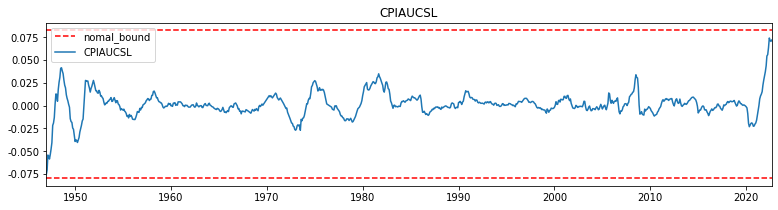

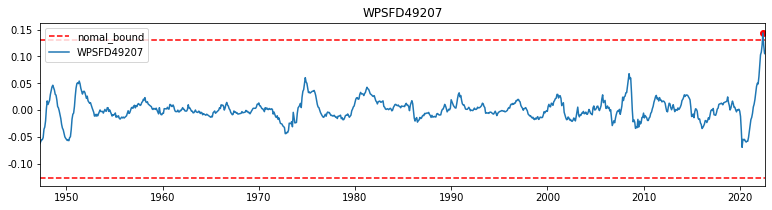

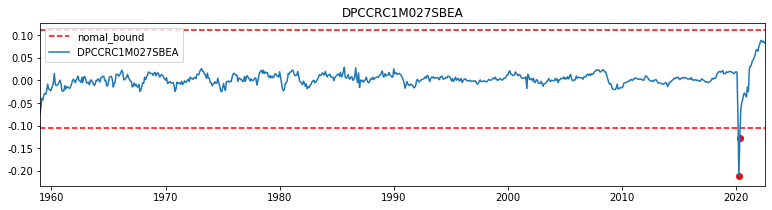

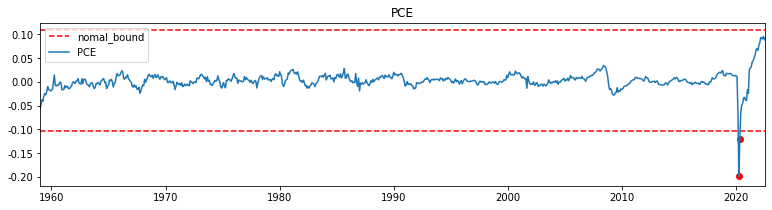

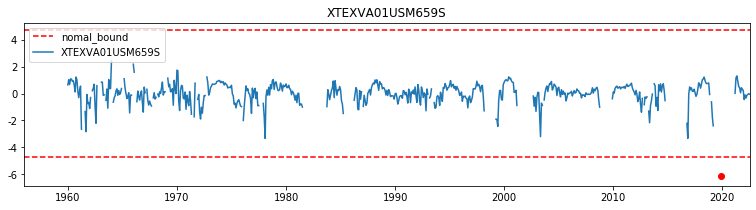

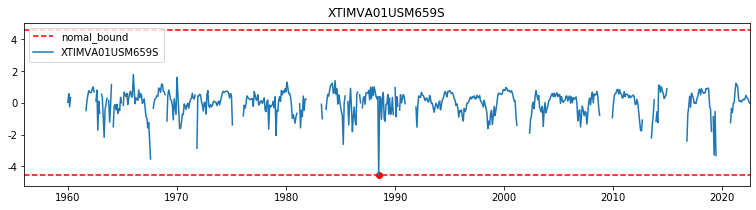

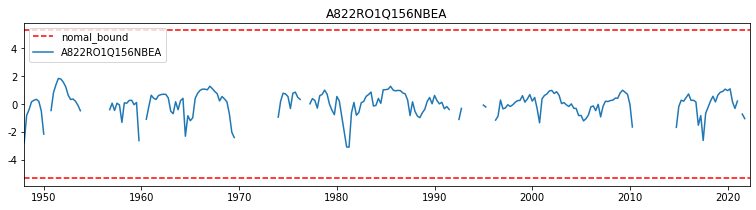

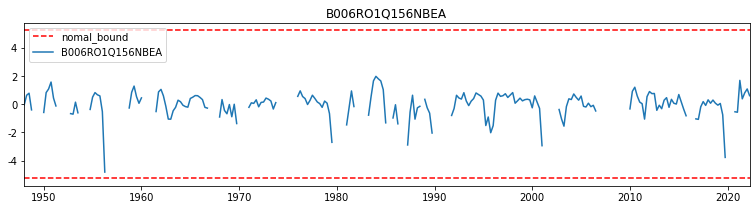

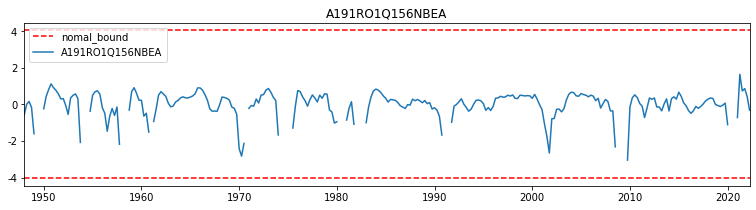

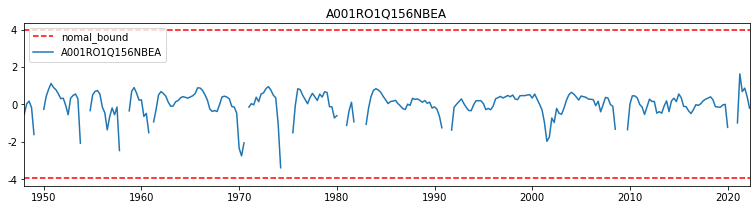

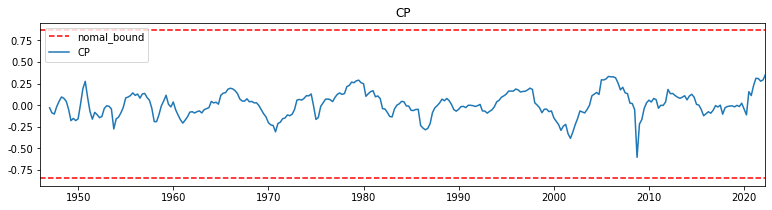

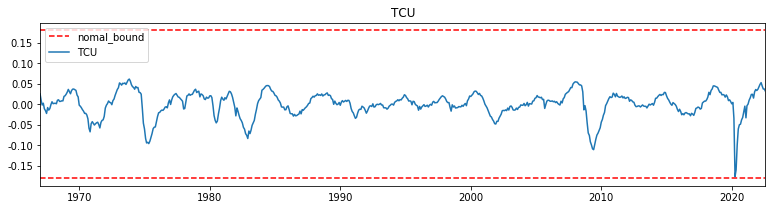

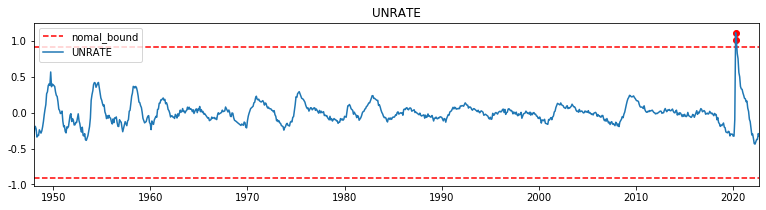

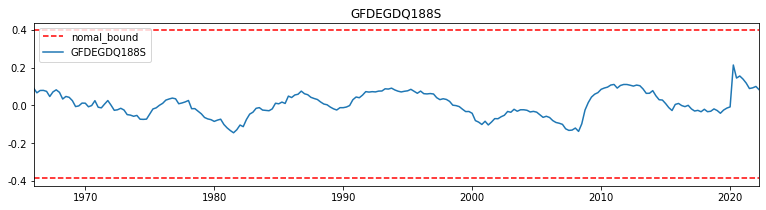

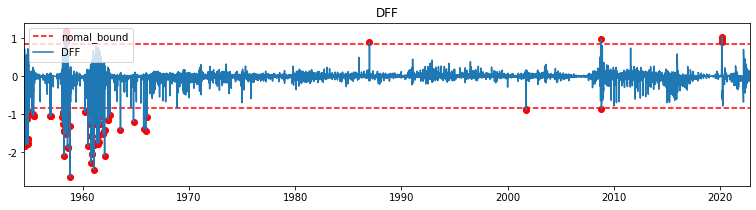

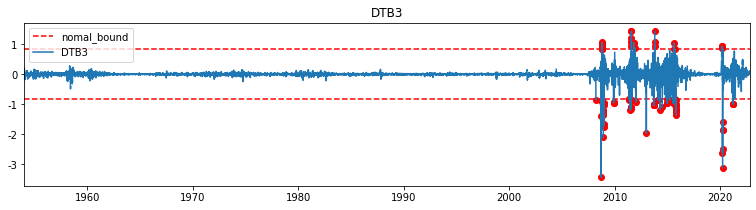

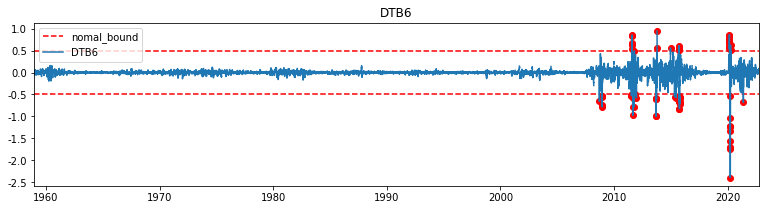

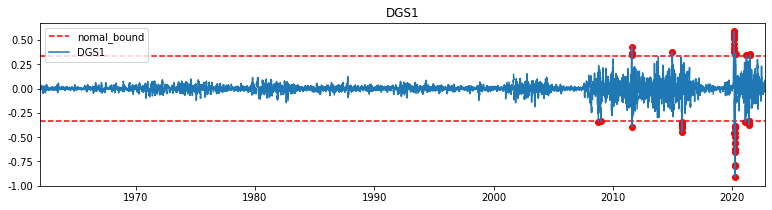

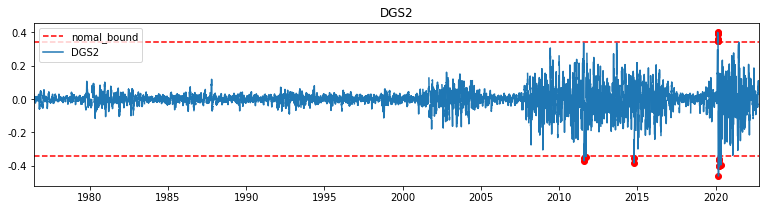

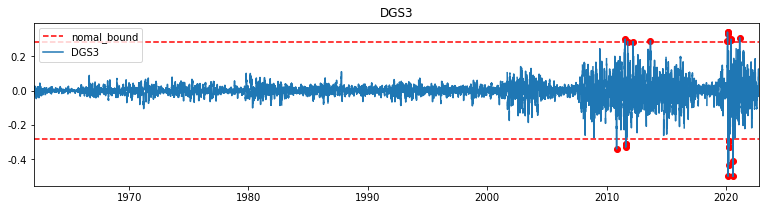

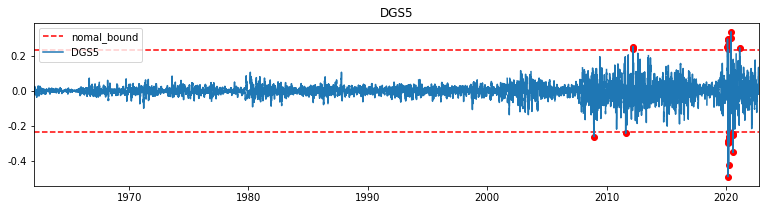

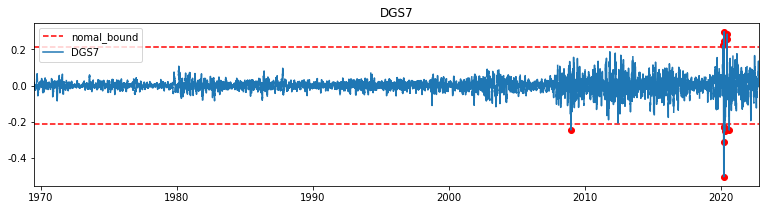

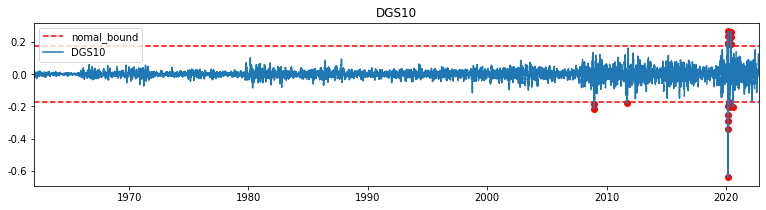

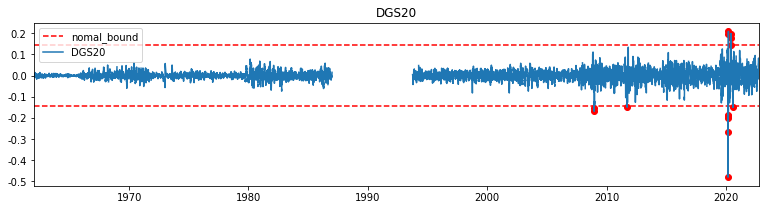

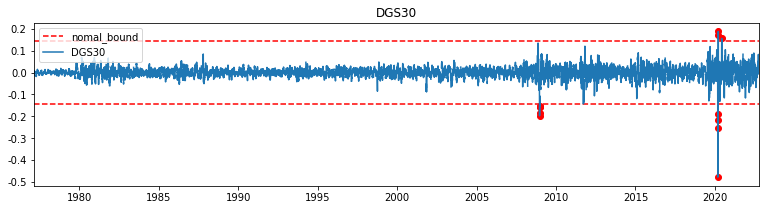

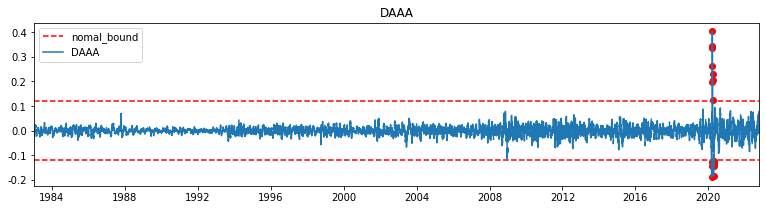

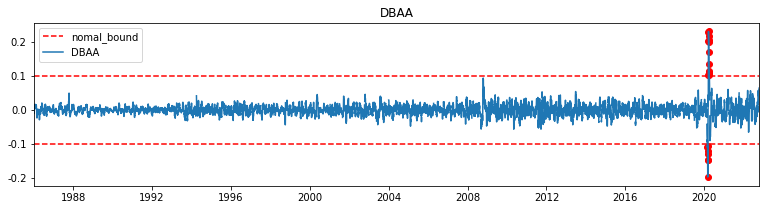

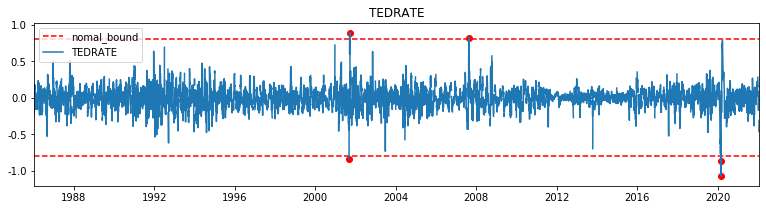

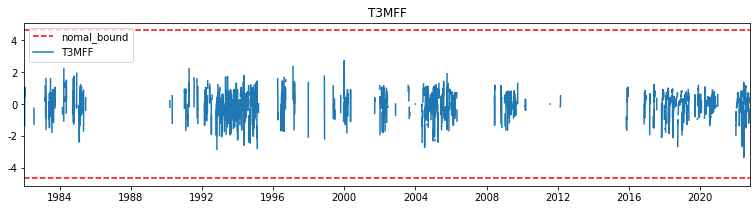

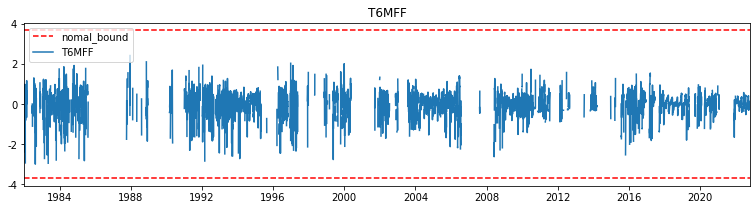

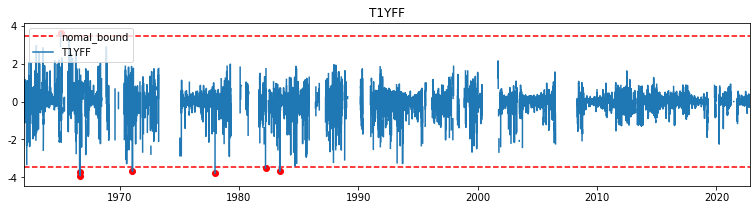

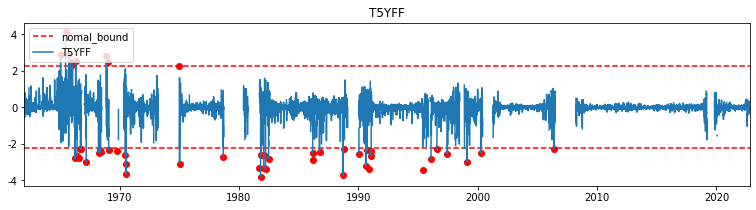

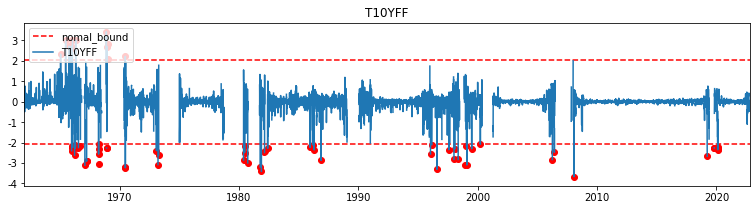

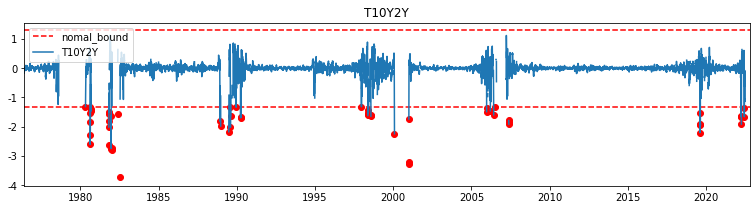

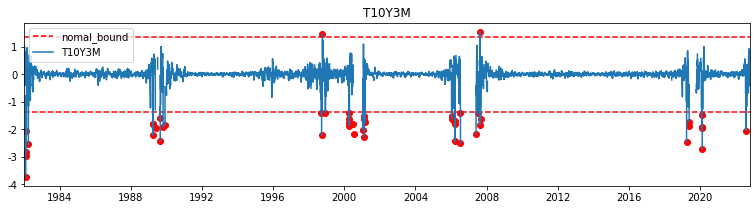

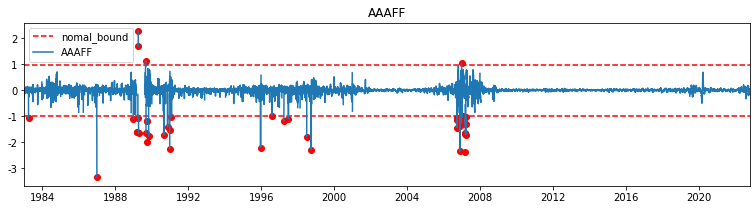

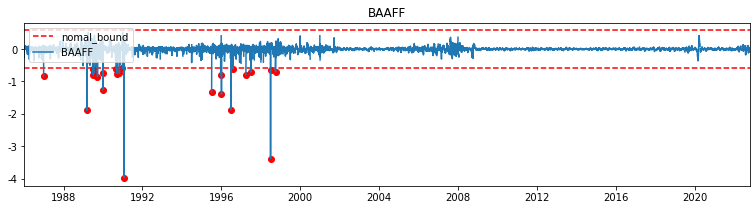

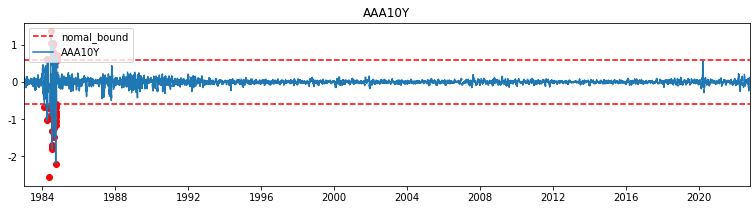

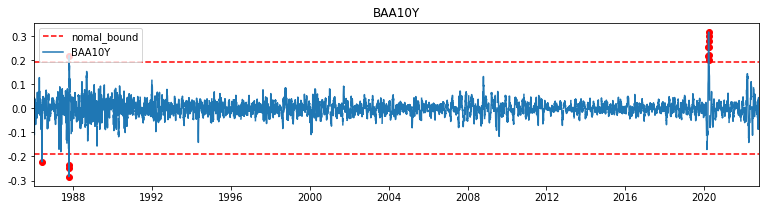

In [13]:
anomaly_date_list = []
anomaly_value_list = []
min_date_list = []
max_date_list = []
for i in macro_list:
    # data read
    anomaly_date,anomaly_value, min_date, max_date = plotting_Risk('{}'.format(i),
                                                                   'smoothing','data_macro'
                                                                   ,'macro_anomaly'
                                                                   ,thres= 6, log_transform=True)
    
    anomaly_date_list = anomaly_date_list + anomaly_date
    anomaly_value_list = anomaly_value_list + anomaly_value
    min_date_list.append(min_date)
    max_date_list.append(max_date)
    

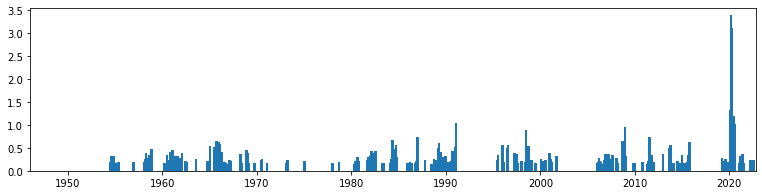

In [14]:

macro_factor = pd.DataFrame(zip(anomaly_date_list,np.abs(anomaly_value_list)), columns = ["date","weight"])
macro_factor = macro_factor.groupby("date")["weight"].sum()
macro_factor = pd.DataFrame(macro_factor).reset_index()
macro_factor['weight'] = macro_factor['weight']/len(macro_list)

fig, ax = plt.subplots(figsize=(13,3))
ax.bar(macro_factor.date,macro_factor.weight,width = 100)
ax.set_xlim([np.min(min_date_list),np.max(max_date_list)])
plt.show()


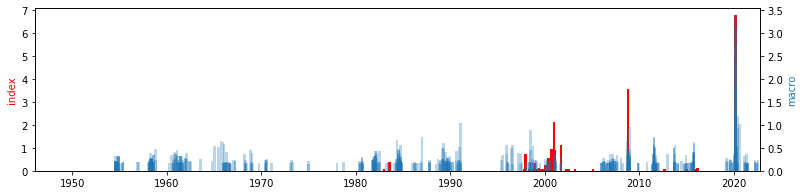

In [15]:
#6
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 100, color = 'red', alpha = 1)
ax.set_ylabel('index', color = 'red') 
ax2 = ax.twinx()
ax2.bar(macro_factor.date,macro_factor.weight,width = 100, color = 'tab:blue', alpha = 0.3)
ax2.set_xlim([np.min(min_date_list),np.max(max_date_list)])
ax2.set_ylabel('macro', color = 'tab:blue')
plt.show()

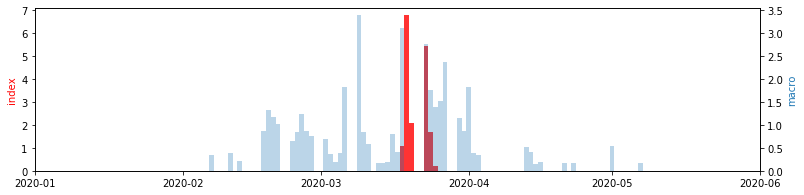

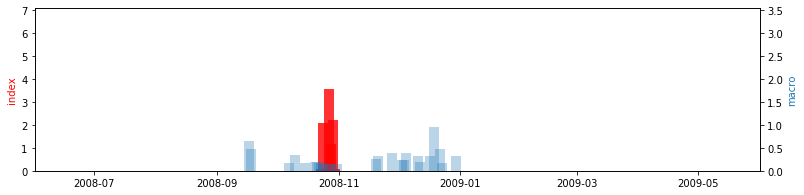

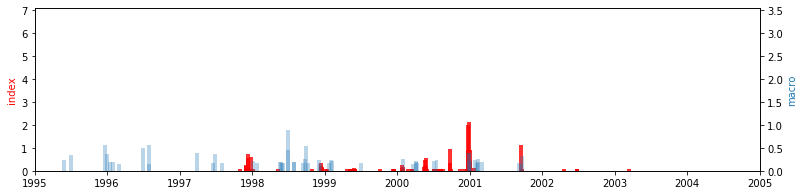

In [16]:
#6
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 1, color = 'red', alpha = 0.8)
ax.set_ylabel('index', color = 'red') 
ax2 = ax.twinx()
ax2.bar(macro_factor.date,macro_factor.weight,width = 1, color = 'tab:blue', alpha = 0.3)
ax2.set_xlim([datetime.strptime('2020-01-01','%Y-%m-%d'),datetime.strptime('2020-06-01','%Y-%m-%d')])
ax2.set_ylabel('macro', color = 'tab:blue')
plt.show()


#6
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 5, color = 'red', alpha = 0.8)
ax.set_ylabel('index', color = 'red') 
ax2 = ax.twinx()
ax2.bar(macro_factor.date,macro_factor.weight,width = 5, color = 'tab:blue', alpha = 0.3)
ax2.set_xlim([datetime.strptime('2008-06-01','%Y-%m-%d'),datetime.strptime('2009-06-01','%Y-%m-%d')])
ax2.set_ylabel('macro', color = 'tab:blue')
plt.show()

#6
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 20, color = 'red', alpha = 0.8)
ax.set_ylabel('index', color = 'red') 
ax2 = ax.twinx()
ax2.bar(macro_factor.date,macro_factor.weight,width = 20, color = 'tab:blue', alpha = 0.3)
ax2.set_xlim([datetime.strptime('1995-01-01','%Y-%m-%d'),datetime.strptime('2005-01-01','%Y-%m-%d')])
ax2.set_ylabel('macro', color = 'tab:blue')
plt.show()

## macro1 거시경제

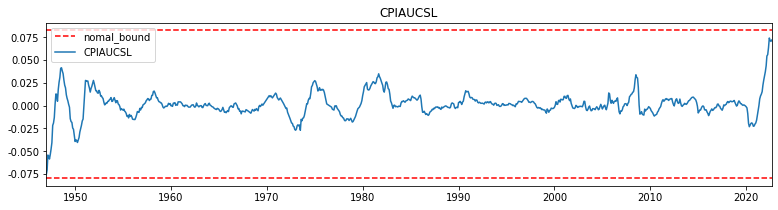

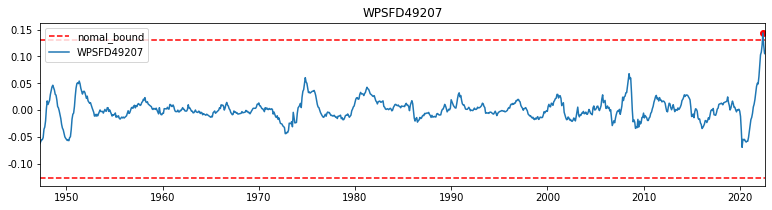

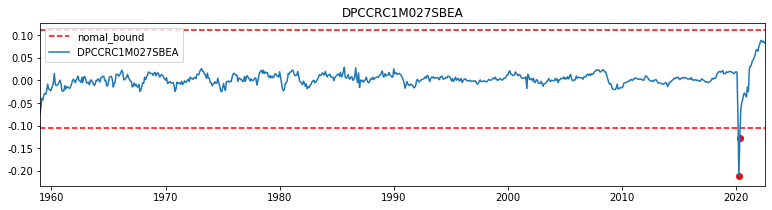

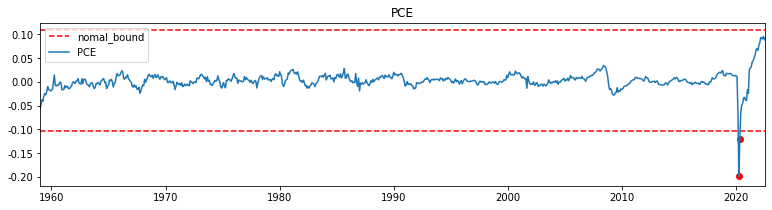

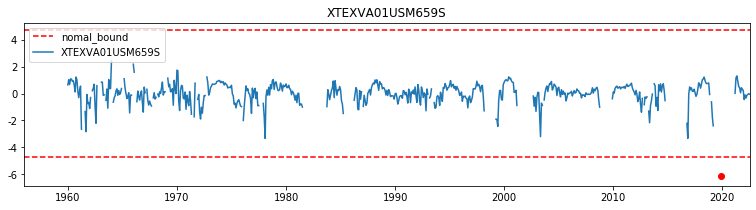

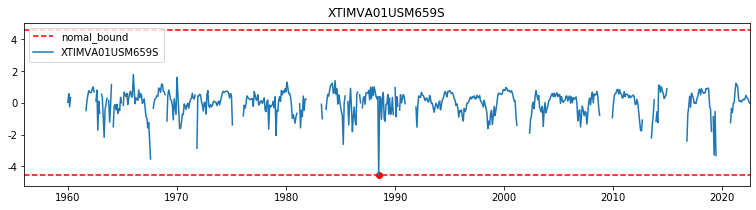

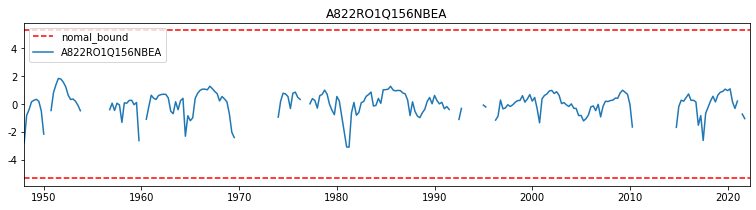

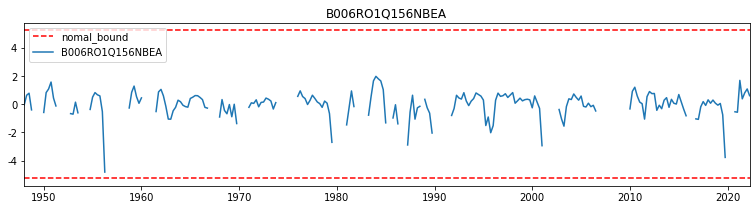

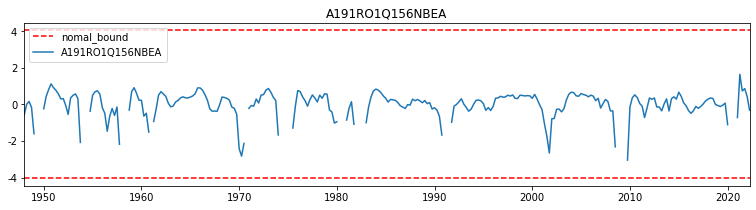

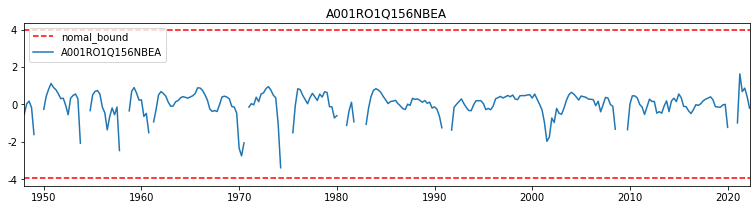

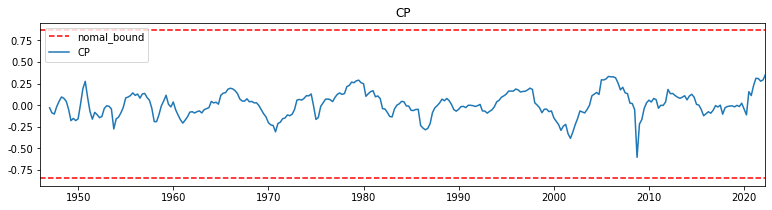

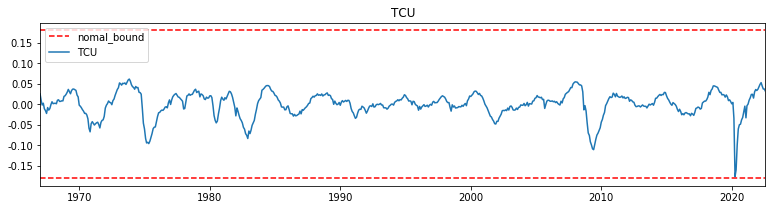

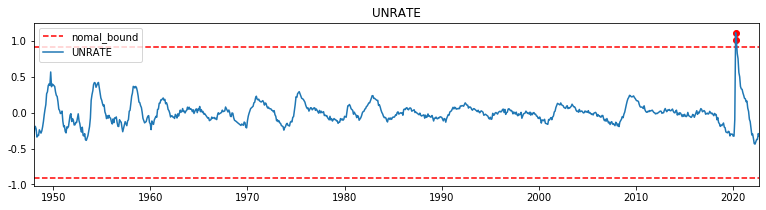

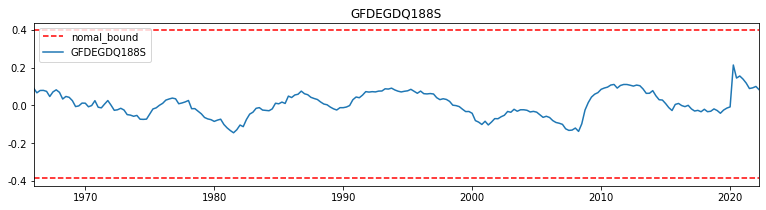

In [17]:
anomaly_date_list1 = []
anomaly_value_list1 = []
min_date_list1 = []
max_date_list1 = []
for i in macro_list1:
    # data read
    anomaly_date,anomaly_value, min_date, max_date = plotting_Risk('{}'.format(i),
                                                                   'smoothing','data_macro'
                                                                   ,'macro_anomaly'
                                                                   ,thres= 6, log_transform=True)
    
    anomaly_date_list1 = anomaly_date_list1 + anomaly_date
    anomaly_value_list1 = anomaly_value_list1 + anomaly_value
    min_date_list1.append(min_date)
    max_date_list1.append(max_date)
    

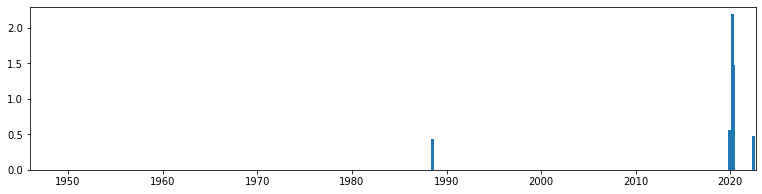

In [18]:

macro_factor1 = pd.DataFrame(zip(anomaly_date_list1,np.abs(anomaly_value_list1)), columns = ["date","weight"])
macro_factor1 = macro_factor1.groupby("date")["weight"].sum()
macro_factor1 = pd.DataFrame(macro_factor1).reset_index()
macro_factor1['weight'] = macro_factor1['weight']/len(macro_list1)

fig, ax = plt.subplots(figsize=(13,3))
ax.bar(macro_factor1.date,macro_factor1.weight,width = 100)
ax.set_xlim([np.min(min_date_list1),np.max(max_date_list1)])
plt.show()


## macro2 금리 스프레드

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


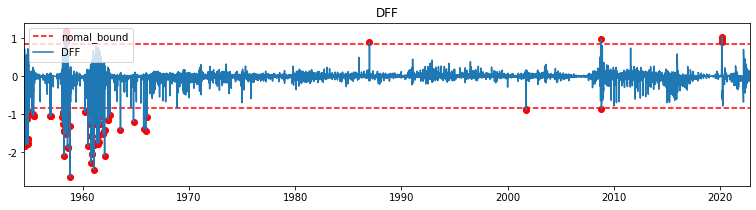

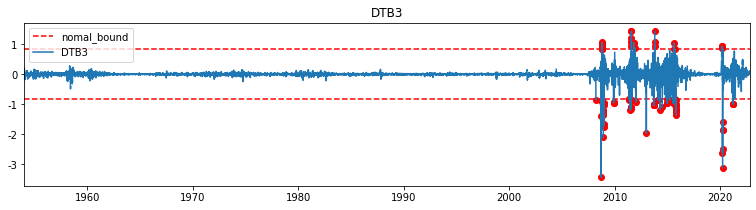

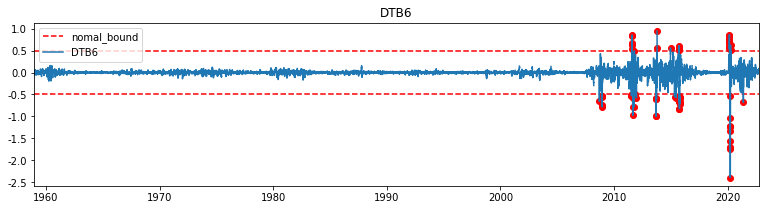

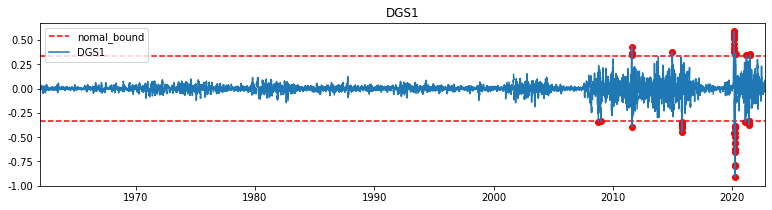

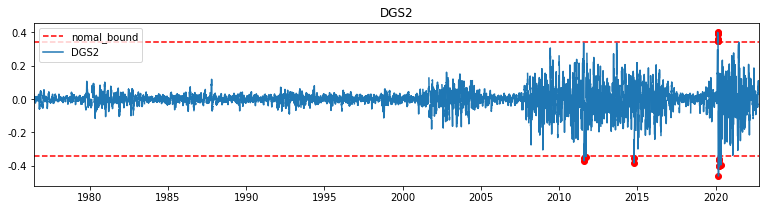

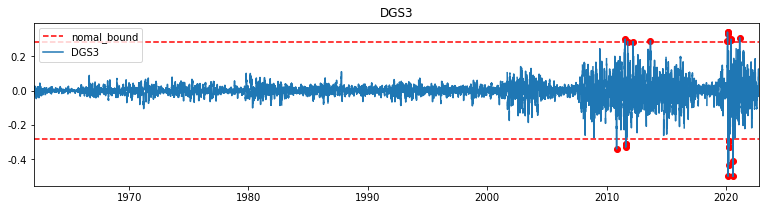

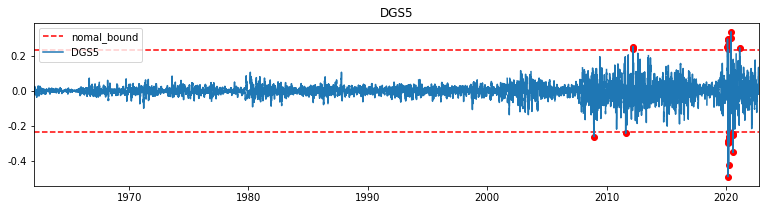

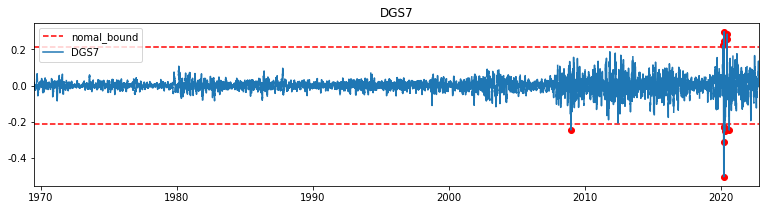

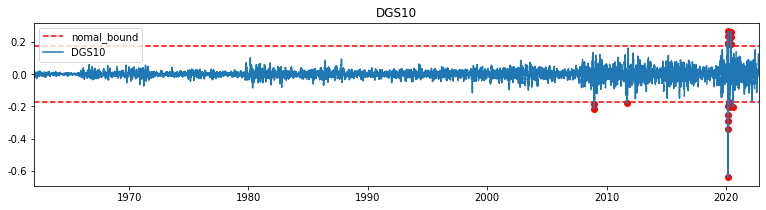

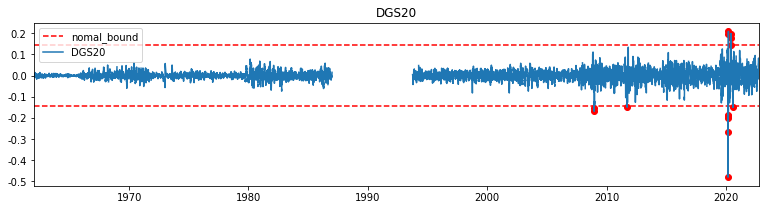

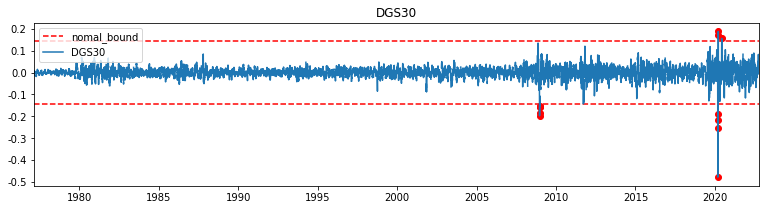

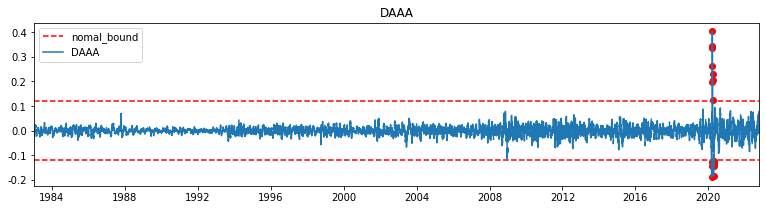

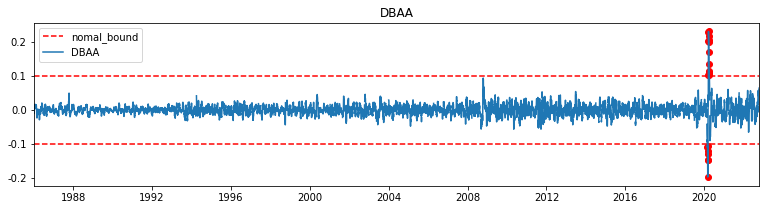

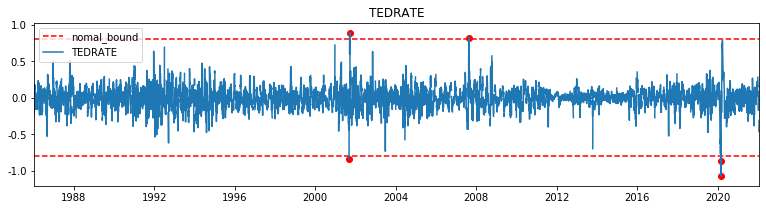

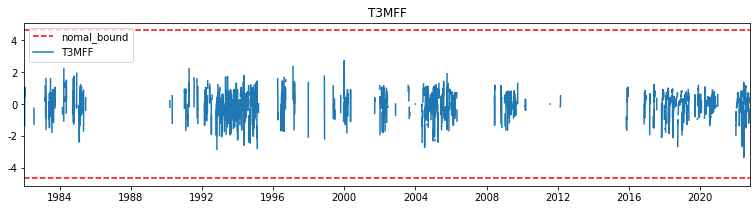

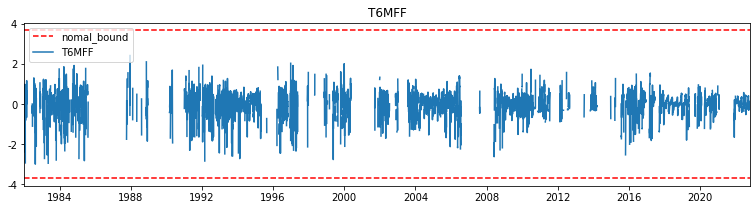

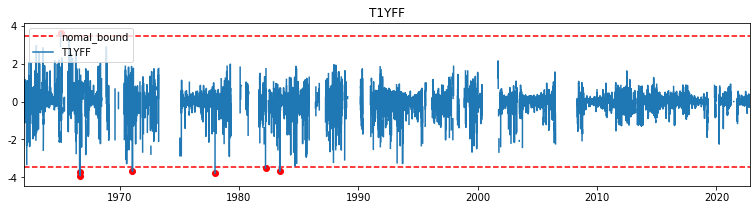

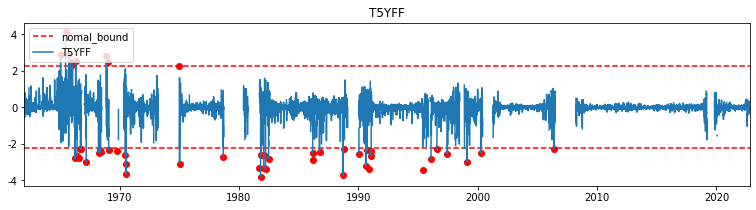

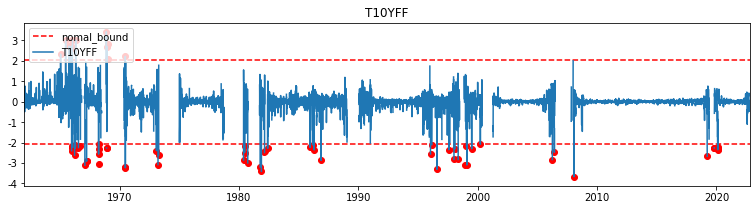

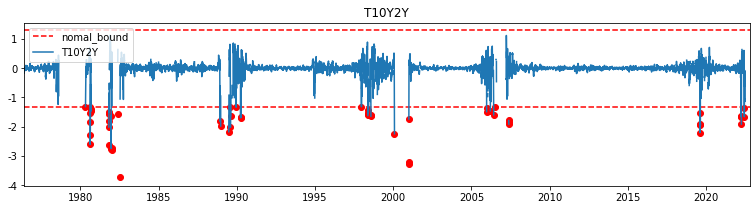

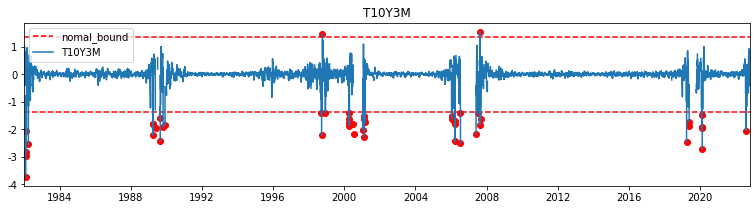

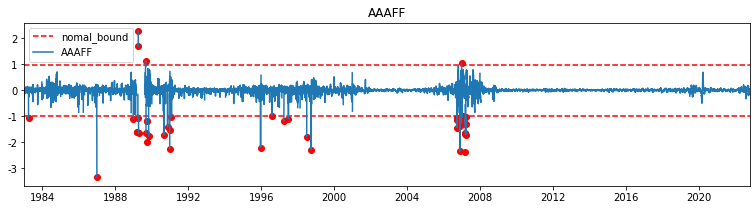

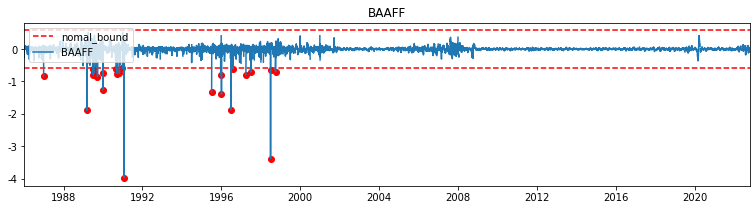

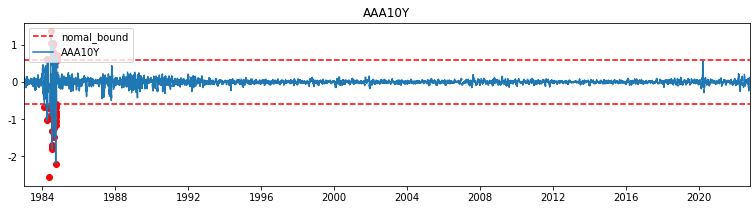

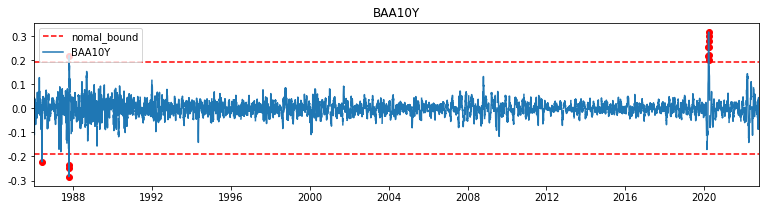

In [19]:
anomaly_date_list2 = []
anomaly_value_list2 = []
min_date_list2 = []
max_date_list2 = []
for i in macro_list2:
    # data read
    anomaly_date,anomaly_value, min_date, max_date = plotting_Risk('{}'.format(i),
                                                                   'smoothing','data_macro'
                                                                   ,'macro_anomaly'
                                                                   ,thres= 6, log_transform=True)
    
    anomaly_date_list2 = anomaly_date_list2 + anomaly_date
    anomaly_value_list2 = anomaly_value_list2 + anomaly_value
    min_date_list2.append(min_date)
    max_date_list2.append(max_date)
    

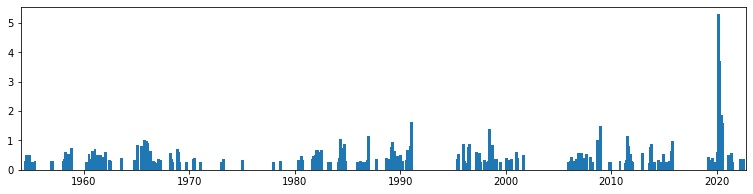

In [20]:

macro_factor2 = pd.DataFrame(zip(anomaly_date_list2,np.abs(anomaly_value_list2)), columns = ["date","weight"])
macro_factor2 = macro_factor2.groupby("date")["weight"].sum()
macro_factor2 = pd.DataFrame(macro_factor2).reset_index()
macro_factor2['weight'] = macro_factor2['weight']/len(macro_list2)

fig, ax = plt.subplots(figsize=(13,3))
ax.bar(macro_factor2.date,macro_factor2.weight,width = 100)
ax.set_xlim([np.min(min_date_list2),np.max(max_date_list2)])
plt.show()


## 비교

- threshold 6

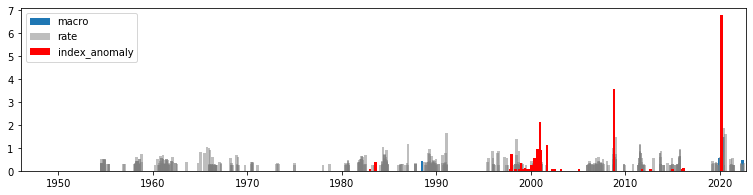

In [21]:
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(macro_factor1.date,macro_factor1.weight,width = 100, alpha = 1, color = 'tab:blue', label = "macro")
ax.bar(macro_factor2.date,macro_factor2.weight,width = 100, alpha = 0.5, color = 'tab:gray', label = "rate")
ax.bar(index_factor.date,index_factor.weight,width = 100, color = 'red', alpha = 1, label = "index_anomaly")
ax.set_xlim([np.min(min_date_list),np.max(max_date_list)])
ax.legend(loc="upper left")
plt.show()


## 경제위기와 비교

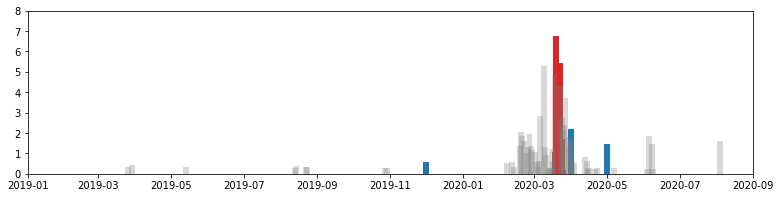

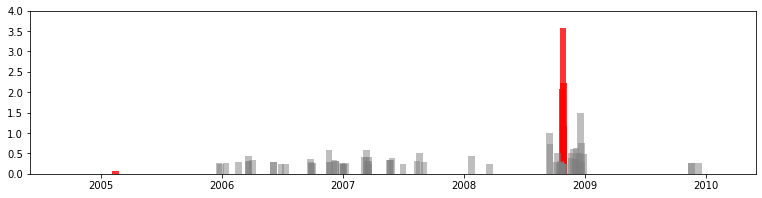

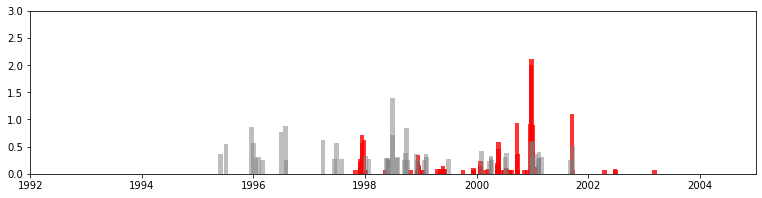

In [22]:
#6
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 5, color = 'tab:red', alpha = 1)
ax.bar(macro_factor1.date,macro_factor1.weight,width = 5, color = 'tab:blue', alpha = 1)
ax.bar(macro_factor2.date,macro_factor2.weight,width = 5, color = 'tab:gray', alpha = 0.3)
ax.set_xlim([datetime.strptime('2019-01-01','%Y-%m-%d'),datetime.strptime('2020-09-01','%Y-%m-%d')])
ax.set_ylim([0,8])
plt.show()

#6
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 20, color = 'red', alpha = 0.8)
ax.bar(macro_factor1.date,macro_factor1.weight,width = 20, color = 'tab:blue', alpha = 1)
ax.bar(macro_factor2.date,macro_factor2.weight,width = 20, color = 'tab:gray', alpha = 0.5)
ax.set_xlim([datetime.strptime('2004-06-01','%Y-%m-%d'),datetime.strptime('2010-06-01','%Y-%m-%d')])
ax.set_ylim([0,4])
plt.show()

#6
fig, ax = plt.subplots(figsize=(13,3))
ax.bar(index_factor.date,index_factor.weight,width = 30, color = 'red', alpha = 0.8)
ax.bar(macro_factor1.date,macro_factor1.weight,width = 30, color = 'tab:blue', alpha = 1)
ax.bar(macro_factor2.date,macro_factor2.weight,width = 30, color = 'tab:gray', alpha = 0.5)
ax.set_xlim([datetime.strptime('1992-01-01','%Y-%m-%d'),datetime.strptime('2005-01-01','%Y-%m-%d')])
ax.set_ylim([0,3])
plt.show()